# scATAC-seq: Comparing chromatin accessibility in young vs aged HSCs

Here I compare chromatin accessibility in hematopoietic stem cells (HSCs) of 10-week-old and 20-month-old mice. 

The [data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE162662) is from work published by [Itokawa et. al.](https://www.nature.com/articles/s41467-022-30440-2) in 2022.

In [1]:
## load packages

library(Signac)
library(Seurat)
library(tidyverse)
library(patchwork) # plots in style of Seurat PBMC tutorial vignette
library(GenomicRanges) # creating peak sets
library(future) # parallel processing
library(EnsDb.Mmusculus.v79) # annotation

Attaching SeuratObject

── Attaching core tidyverse packages ─────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ purrr::reduce() masks Signac::reduce()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd,

In [2]:
# Suppress warnings
options(warn = -1)

In [3]:
# change the current plan to access parallelization
plan("multisession", workers = 28)
plan()

multisession:
- args: function (..., workers = 28, envir = parent.frame())
- tweaked: TRUE
- call: plan("multisession", workers = 28)

In [4]:
# increase size of plots from default
options(repr.plot.width = 14, 
        repr.plot.height = 14) # from 7, 7

## Create common peak set

Peaks were originally called on the individual datasets (young HSCs and aged HSCs) but for this analysis of differential accessibility, the datasets need to be merged.

"When merging multiple single-cell chromatin datasets, it’s important to be aware that if peak calling was performed on each dataset independently, the peaks are unlikely to be exactly the same. We therefore need to create a common set of peaks across all the datasets to be merged."

In [5]:
# load peaks called on individual datasets
young_peaks <- read.table(
  file = "youngPeaks.txt",
  col.names = c("chr", "start", "end")
)
aged_peaks <- read.table(
  file = "agedPeaks.txt",
  col.names = c("chr", "start", "end")
)
young_peaks <- makeGRangesFromDataFrame(young_peaks)
aged_peaks <- makeGRangesFromDataFrame(aged_peaks)

# create common peak set
common_peaks <- reduce(x = c(young_peaks, aged_peaks))
common_peaks

GRanges object with 206751 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1   3670354-3672753      *
       [2]     chr1   3993219-3994009      *
       [3]     chr1   4173610-4174396      *
       [4]     chr1   4228073-4228612      *
       [5]     chr1   4234171-4234350      *
       ...      ...               ...    ...
  [206747]     chrY 90737333-90745058      *
  [206748]     chrY 90761101-90762146      *
  [206749]     chrY 90797309-90798064      *
  [206750]     chrY 90798741-90809562      *
  [206751]     chrY 90810170-90813986      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths

Here `reduce()` returns the union of the peaks in the two datasets with overlapping peaks being merged into a single peak. See `?IRanges::reduce` and the [Signac tutorial on merging datasets](https://stuartlab.org/signac/articles/merging)

---
We then filter out peaks that are too narrow or too wide.

In [6]:
# Filter out "bad" peaks based on width
peakwidths <- width(common_peaks)
common_peaks <- common_peaks[peakwidths  < 10000 & peakwidths > 20]
common_peaks

GRanges object with 199535 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1   3670354-3672753      *
       [2]     chr1   3993219-3994009      *
       [3]     chr1   4173610-4174396      *
       [4]     chr1   4228073-4228612      *
       [5]     chr1   4234171-4234350      *
       ...      ...               ...    ...
  [199531]     chrY 90732168-90732574      *
  [199532]     chrY 90737333-90745058      *
  [199533]     chrY 90761101-90762146      *
  [199534]     chrY 90797309-90798064      *
  [199535]     chrY 90810170-90813986      *
  -------
  seqinfo: 21 sequences from an unspecified genome; no seqlengths

This reduces our feature set of common peaks from 206,751 to 199,535

---

## Create fragment objects

We then load metadata on each barcode ("cell"). This file is [one of the outputs of the Cell Ranger ATAC pipeline](https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/singlecell) and contains information on each barcode such as: the total number of fragments, number of fragments overlapping transcription start site (TSS) regions, blacklist regions, promoter regions, enhancer regions, etc. These will come in handy when filtering out poor quality cells.

In [7]:
# load metadata
metadata_young <- read.table(
  file = "GSM5723631_Young_HSC_singlecell.csv",
  stringsAsFactors = FALSE,
  sep = ",",
  header = TRUE,
  row.names = 1
)[-1, ] # remove 1st row containing summary of frags not associated with any whitelisted barcodes
metadata_aged <- read.table(
  file = "GSM5723632_Aged_HSC_singlecell.csv",
  stringsAsFactors = FALSE,
  sep = ",",
  header = TRUE,
  row.names = 1
)[-1, ] # remove 1st containing summary of frags not associated with any whitelisted barcodes

head(metadata_young)
head(metadata_aged)

total duplicate chimeric unmapped lowmapq mitochondrial
AAACGAAAGAAAGCAG-1  1    1         0        0        0       0            
AAACGAAAGAAATACC-1  1    0         0        0        0       0            
AAACGAAAGAACCATA-1  4    0         0        0        0       0            
AAACGAAAGAACCCGA-1  1    0         0        0        0       0            
AAACGAAAGAACGACC-1  1    0         0        1        0       0            
AAACGAAAGAACGTCG-1 20    1         0        8        1       2            
                   passed_filters cell_id is__cell_barcode TSS_fragments
AAACGAAAGAAAGCAG-1 0              None    0                0            
AAACGAAAGAAATACC-1 1              None    0                1            
AAACGAAAGAACCATA-1 4              None    0                1            
AAACGAAAGAACCCGA-1 1              None    0                1            
AAACGAAAGAACGACC-1 0              None    0                0            
AAACGAAAGAACGTCG-1 8              None    0                3            
                   DNase_sensitive_region_fragments enhancer_region_fragments
AAACGAAAGAAAGCAG-1 0                                0                        
AAACGAAAGAAATACC-1 1                                0                        
AAACGAAAGAACCATA-1 2                                1                        
AAACGAAAGAACCCGA-1 0                                0                        
AAACGAAAGAACGACC-1 0                                0                        
AAACGAAAGAACGTCG-1 1                                1                        
                   promoter_region_fragments on_target_fragments
AAACGAAAGAAAGCAG-1 0                         0                  
AAACGAAAGAAATACC-1 1                         1                  
AAACGAAAGAACCATA-1 2                         3                  
AAACGAAAGAACCCGA-1 1                         1                  
AAACGAAAGAACGACC-1 0                         0                  
AAACGAAAGAACGTCG-1 0                         3                  
                   blacklist_region_fragments peak_region_fragments
AAACGAAAGAAAGCAG-1 0                          0                    
AAACGAAAGAAATACC-1 0                          1                    
AAACGAAAGAACCATA-1 0                          3                    
AAACGAAAGAACCCGA-1 0                          1                    
AAACGAAAGAACGACC-1 0                          0                    
AAACGAAAGAACGTCG-1 0                          2                    
                   peak_region_cutsites
AAACGAAAGAAAGCAG-1 0                   
AAACGAAAGAAATACC-1 2                   
AAACGAAAGAACCATA-1 6                   
AAACGAAAGAACCCGA-1 2                   
AAACGAAAGAACGACC-1 0                   
AAACGAAAGAACGTCG-1 4

total duplicate chimeric unmapped lowmapq mitochondrial
AAACGAAAGAAATTCG-1  1    0         0        0        0       0            
AAACGAAAGAACGACC-1  1    0         0        0        0       0            
AAACGAAAGAACGCCA-1 37    2         0        6        8       1            
AAACGAAAGAACTCCT-1 26    3         0        1        6       0            
AAACGAAAGAAGCCTG-1 47    4         1        7        5       0            
AAACGAAAGACACAAT-1  1    0         0        0        0       0            
                   passed_filters cell_id is__cell_barcode TSS_fragments
AAACGAAAGAAATTCG-1  1             None    0                0            
AAACGAAAGAACGACC-1  1             None    0                0            
AAACGAAAGAACGCCA-1 20             None    0                5            
AAACGAAAGAACTCCT-1 16             None    0                1            
AAACGAAAGAAGCCTG-1 30             None    0                1            
AAACGAAAGACACAAT-1  1             None    0                1            
                   DNase_sensitive_region_fragments enhancer_region_fragments
AAACGAAAGAAATTCG-1 0                                 1                       
AAACGAAAGAACGACC-1 1                                 1                       
AAACGAAAGAACGCCA-1 4                                 2                       
AAACGAAAGAACTCCT-1 3                                 1                       
AAACGAAAGAAGCCTG-1 8                                10                       
AAACGAAAGACACAAT-1 1                                 0                       
                   promoter_region_fragments on_target_fragments
AAACGAAAGAAATTCG-1 0                          1                 
AAACGAAAGAACGACC-1 0                          1                 
AAACGAAAGAACGCCA-1 1                          8                 
AAACGAAAGAACTCCT-1 0                          3                 
AAACGAAAGAAGCCTG-1 0                         11                 
AAACGAAAGACACAAT-1 1                          1                 
                   blacklist_region_fragments peak_region_fragments
AAACGAAAGAAATTCG-1 0                          1                    
AAACGAAAGAACGACC-1 0                          1                    
AAACGAAAGAACGCCA-1 0                          3                    
AAACGAAAGAACTCCT-1 0                          3                    
AAACGAAAGAAGCCTG-1 0                          5                    
AAACGAAAGACACAAT-1 0                          1                    
                   peak_region_cutsites
AAACGAAAGAAATTCG-1  2                  
AAACGAAAGAACGACC-1  2                  
AAACGAAAGAACGCCA-1  6                  
AAACGAAAGAACTCCT-1  5                  
AAACGAAAGAAGCCTG-1 10                  
AAACGAAAGACACAAT-1  2

We do a preliminary filter of barcodes ("cells") containing too few fragments-of-interest

In [8]:
# perform an initial filtering of low count "cells" (barcodes)
nrow(metadata_young)
nrow(metadata_aged)

metadata_young <- metadata_young[metadata_young$passed_filters > 500, ]
metadata_aged <- metadata_aged[metadata_aged$passed_filters > 500, ]

nrow(metadata_young)
nrow(metadata_aged)

[1] 239185

[1] 217516

[1] 5749

[1] 4501

In [9]:
nrow(metadata_young)

[1] 5749

This reduces our "cells" from over 200,000 each to 5,749 and 4,501 for young and aged mice respectively (~98% drop)

---

In [10]:
# create fragment objects
frags_young <- CreateFragmentObject(
  path = "GSM5723631_Young_HSC_fragments.tsv.gz",
  cells = rownames(metadata_young)
)
frags_aged <- CreateFragmentObject(
  path = "GSM5723632_Aged_HSC_fragments.tsv.gz",
  cells = rownames(metadata_aged)
)
frags_young
frags_aged
str(frags_young)
str(frags_aged)

Computing hash

Computing hash



A Fragment object for 5749 cells

A Fragment object for 4501 cells

Formal class 'Fragment' [package "Signac"] with 3 slots
  ..@ path : chr "/home/fmbuga/scATAC/data/Itokawa22HSC/GSM5723631_Young_HSC_fragments.tsv.gz"
  ..@ hash : chr [1:2] "de9cc48c4bc6b48219796cb399ee82cb" "386e1277c372504c5e898cd126ca11ee"
  ..@ cells: Named chr [1:5749] "AAACGAAAGTGATTAG-1" "AAACGAAAGTTCAACC-1" "AAACGAACAAATTGAG-1" "AAACGAACAAGCAGGT-1" ...
  .. ..- attr(*, "names")= chr [1:5749] "AAACGAAAGTGATTAG-1" "AAACGAAAGTTCAACC-1" "AAACGAACAAATTGAG-1" "AAACGAACAAGCAGGT-1" ...
Formal class 'Fragment' [package "Signac"] with 3 slots
  ..@ path : chr "/home/fmbuga/scATAC/data/Itokawa22HSC/GSM5723632_Aged_HSC_fragments.tsv.gz"
  ..@ hash : chr [1:2] "655a385c8aadffbcc4e4cffceed643eb" "3eb811b19804e11491417459c1726b20"
  ..@ cells: Named chr [1:4501] "AAACGAAAGAGGAACA-1" "AAACGAAAGAGGTCCA-1" "AAACGAAAGTATGCTC-1" "AAACGAAAGTGTCGGA-1" ...
  .. ..- attr(*, "names")= chr [1:4501] "AAACGAAAGAGGAACA-1" "AAACGAAAGAGGTCCA-1" "AAACGAAAGTATGCTC-1" "AAACGAAAGTGTCGGA-1" ...


## Quantify peaks in each dataset

Now we count for each cell, how many fragments were mapped to each of the 199,535 peaks/features (regions of the DNA that were accessible to the Tn5 transposase). This gives us a feature-barcode matrix where each element of the matrix is the number of cut sites associated with a feature and barcode ("cell"). This is similar to [one of the matrices output by Cell Ranger ATAC count](https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/matrices).

In [11]:
young_counts <- FeatureMatrix(
  fragments = frags_young,
  features = common_peaks,
  cells = rownames(metadata_young)
)

aged_counts <- FeatureMatrix(
  fragments = frags_aged,
  features = common_peaks,
  cells = rownames(metadata_aged)
) # ~6 minutes

str(young_counts)
dim(young_counts)
str(aged_counts)
dim(aged_counts)

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:34294306] 42 57 60 74 104 106 130 142 169 182 ...
  ..@ p       : int [1:5750] 0 8187 11835 18248 26697 32615 38914 47233 52931 60219 ...
  ..@ Dim     : int [1:2] 199535 5749
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:199535] "chr1-3670354-3672753" "chr1-3993219-3994009" "chr1-4173610-4174396" "chr1-4228073-4228612" ...
  .. ..$ : chr [1:5749] "AAACGAAAGTGATTAG-1" "AAACGAAAGTTCAACC-1" "AAACGAACAAATTGAG-1" "AAACGAACAAGCAGGT-1" ...
  ..@ x       : num [1:34294306] 1 1 1 1 3 1 1 1 1 1 ...
  ..@ factors : list()


[1] 199535   5749

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:28533367] 1963 2002 2172 2184 2196 2270 5433 6004 7066 7831 ...
  ..@ p       : int [1:4502] 0 134 356 6008 15019 20899 28399 36495 48927 58587 ...
  ..@ Dim     : int [1:2] 199535 4501
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:199535] "chr1-3670354-3672753" "chr1-3993219-3994009" "chr1-4173610-4174396" "chr1-4228073-4228612" ...
  .. ..$ : chr [1:4501] "AAACGAAAGAGGAACA-1" "AAACGAAAGAGGTCCA-1" "AAACGAAAGTATGCTC-1" "AAACGAAAGTGTCGGA-1" ...
  ..@ x       : num [1:28533367] 1 1 1 1 1 1 1 1 1 1 ...
  ..@ factors : list()


[1] 199535   4501

## Create chromatin assay and Seurat objects

In [12]:
young_assay <- CreateChromatinAssay(young_counts, fragments = frags_young)
young <- CreateSeuratObject(young_assay, assay = "ATAC", meta.data=metadata_young)

aged_assay <- CreateChromatinAssay(aged_counts, fragments = frags_aged)
aged <- CreateSeuratObject(aged_assay, assay = "ATAC", meta.data=metadata_aged)

young
aged

An object of class Seurat 
199535 features across 5749 samples within 1 assay 
Active assay: ATAC (199535 features, 0 variable features)

An object of class Seurat 
199535 features across 4501 samples within 1 assay 
Active assay: ATAC (199535 features, 0 variable features)

## Merge the Seurat objects

In [13]:
# add information to identify dataset of origin
young$dataset <- 'young'
aged$dataset <- 'aged'

# merge the datasets, adding a cell ID to make sure cell names are unique
combined <- merge(
  x = young,
  y = aged,
  add.cell.ids = c("young", "aged")
) # ~10 seconds

combined[["ATAC"]]

ChromatinAssay data with 199535 features for 10250 cells
Variable features: 0 
Genome: 
Annotation present: FALSE 
Motifs present: FALSE 
Fragment files: 2 

## Annotate the combined Seurat object

In [14]:
# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)

# change to UCSC style 
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "mm10"

# add the gene information to the object
Annotation(combined) <- annotations

combined

An object of class Seurat 
199535 features across 10250 samples within 1 assay 
Active assay: ATAC (199535 features, 0 variable features)

## QC filtering

We now filter out poor quality cells using [five recommended metrics](https://stuartlab.org/signac/articles/pbmc_vignette#computing-qc-metrics):
- peak region fragments
- transcription start site (TSS) enrichment score
- blacklist ratio
- nucleosome signal
- fraction of reads in peaks

In [15]:
# function to filter dataset on 5 QC metrics

qc_filter <- function(dataset){
    # compute QC metrics for each cell
    dataset <- NucleosomeSignal(object = dataset) # nucleosome signal score
    dataset <- TSSEnrichment(object = dataset, fast = FALSE) # TSS enrichment score
    dataset$pct_reads_in_peaks <- dataset$peak_region_fragments / dataset$passed_filters * 100 # fraction reads in peaks
    dataset$blacklist_ratio <- dataset$blacklist_region_fragments / dataset$peak_region_fragments # blacklist ratio

    # plot QC metrics PRE-filter
    print(
    VlnPlot(
      object = dataset,
      features = c('peak_region_fragments', 'TSS.enrichment', 'blacklist_ratio', 
                   'nucleosome_signal', 'pct_reads_in_peaks'),
      pt.size = 0.1,
      ncol = 5
    )) # print required to display
    
    # filter cells based on the 5 QC metrics (what cutoffs did the paper use? probs here are arbitrary)
    low_prf <- quantile(dataset[["peak_region_fragments"]]$peak_region_fragments, probs = 0.025)
    high_prf <- quantile(dataset[["peak_region_fragments"]]$peak_region_fragments, probs = 0.975)
    low_prp <- quantile(dataset[["pct_reads_in_peaks"]]$pct_reads_in_peaks, probs = 0.05)
    high_blr <- quantile(dataset[["blacklist_ratio"]]$blacklist_ratio, probs = 0.95)
    high_ns <- quantile(dataset[["nucleosome_signal"]]$nucleosome_signal, probs = 0.95)
    low_ts <- quantile(dataset[["TSS.enrichment"]]$TSS.enrichment, probs = 0.05)

    dataset <- subset(
                  x = dataset,
                  subset = peak_region_fragments > low_prf &
                            peak_region_fragments < high_prf &
                            pct_reads_in_peaks > low_prp &
                            blacklist_ratio < high_blr &
                            nucleosome_signal < high_ns &
                            TSS.enrichment > low_ts
    )
    return(dataset)    
}

An object of class Seurat 
199535 features across 10250 samples within 1 assay 
Active assay: ATAC (199535 features, 0 variable features)

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



An object of class Seurat 
199535 features across 8491 samples within 1 assay 
Active assay: ATAC (199535 features, 0 variable features)

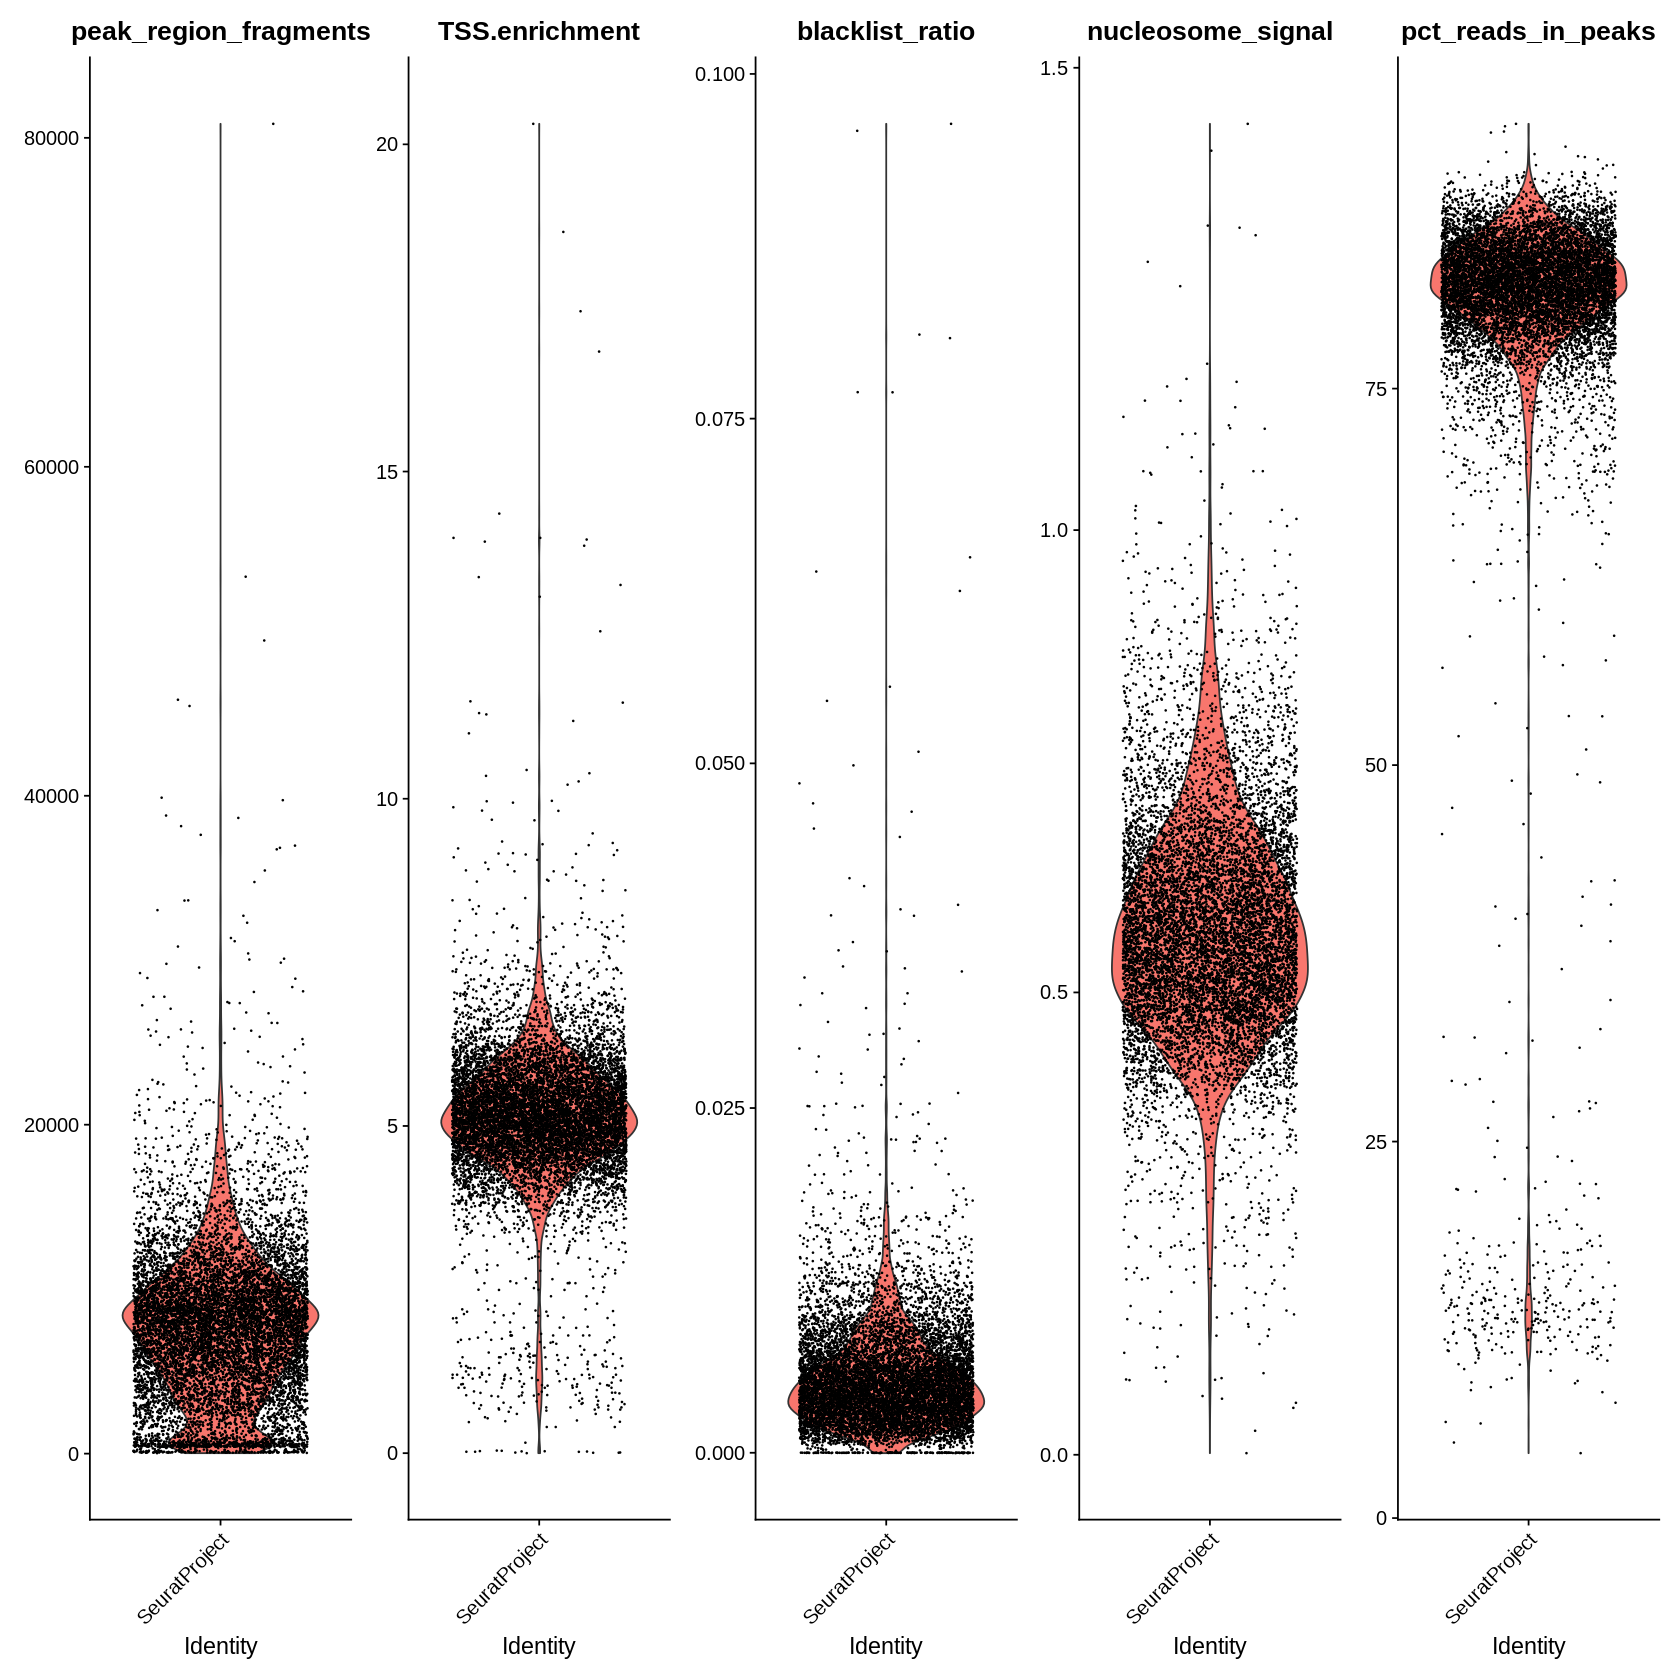

In [16]:
# do QC filter to exclude low quality cells
combined
combined <- qc_filter(combined) # ~200s
combined

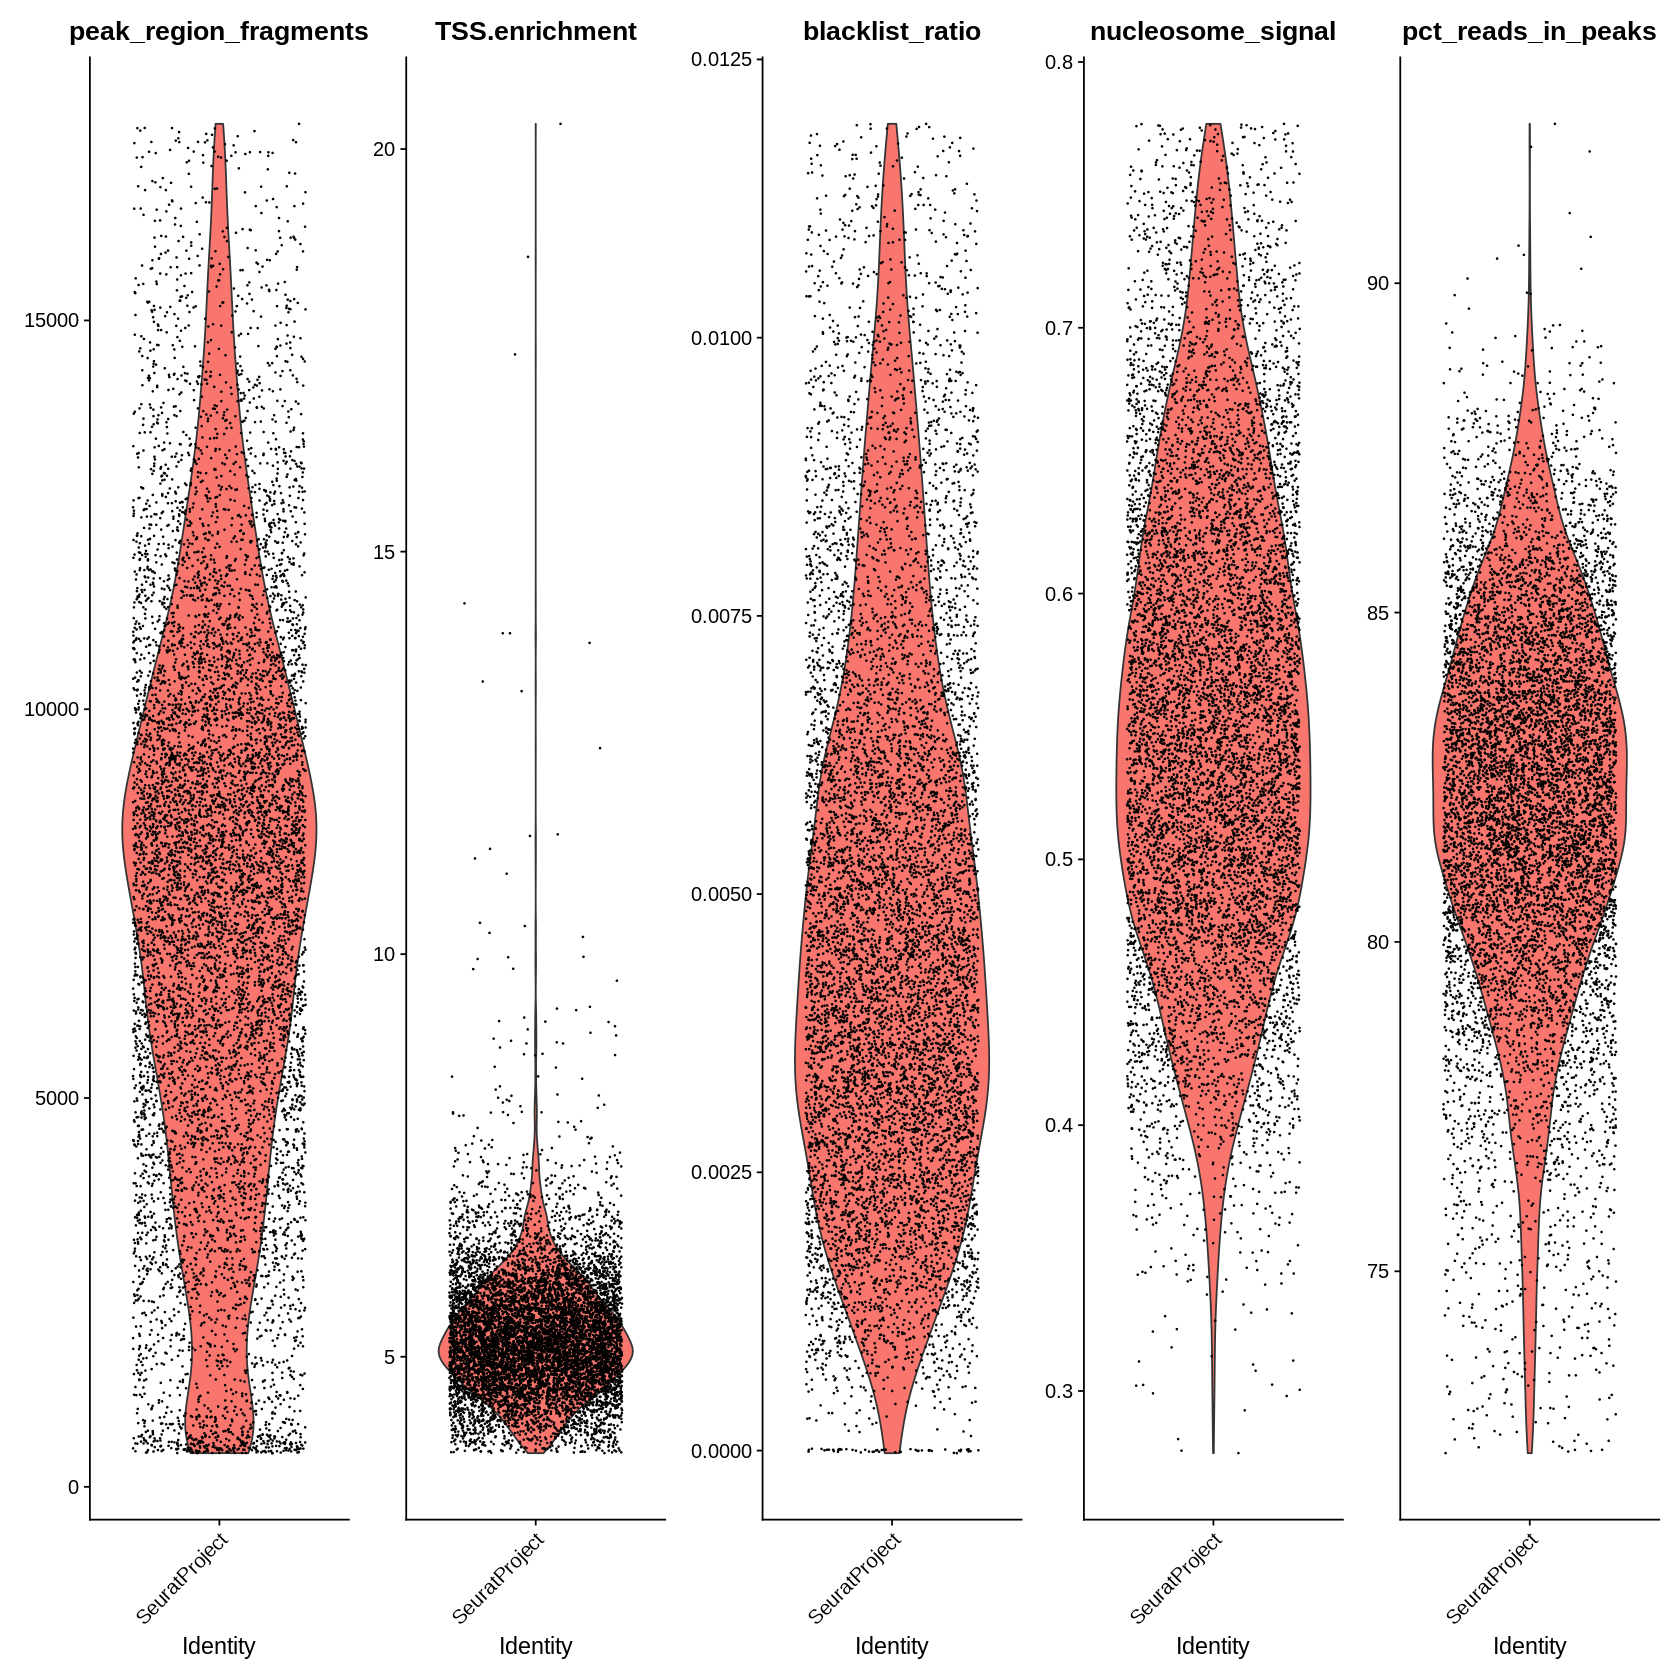

In [17]:
# plot QC metrics POST-filter
VlnPlot(
  object = combined,
  features = c('peak_region_fragments', 'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal', 'pct_reads_in_peaks'),
  pt.size = 0.1,
  ncol = 5
)

The QC filtering has removed cells with:
- very low and very high peak region fragments
- low fraction of reads in peaks
- low TSS enrichment score
- high blacklist ratio and
- high nucleosome signal

This leaves us with 8,941 cells that will be used for the rest of the analysis.

## Normalization (TF-IDF) and linear dimensional reduction (SVD); TF-IDF + SVD = LSI

Next, we do term-frequency inverse-document-frequency (TF-IDF) normalization of the cell-peak matrix. This normalizes across cells to correct for differences in cellular sequencing depth, and across peaks to give higher values to more rare peaks. This is followed by linear dimension reduction using singular value decomposition (SVD) where only peaks found in more than 20 cells are used for the reduction. The combination of TF-IDF followed by SVD is called latent semantic indexing (LSI).

In [18]:
# Normalization (TF-IDF) and linear dimensional reduction (SVD); TF-IDF + SVD = LSI
combined <- RunTFIDF(combined) %>% 
              FindTopFeatures(min.cutoff = 20) %>% 
                RunSVD()
combined

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



An object of class Seurat 
199535 features across 8491 samples within 1 assay 
Active assay: ATAC (199535 features, 153781 variable features)
 1 dimensional reduction calculated: lsi

## Graph-based clustering & non-linear dimension reduction for visualization

The LSI reduces the dimensionality of the data from the 199,535 features to 50 dimensions (the default value of the `RunSVD()` function). We can now cluster the cells in the low-dimensional LSI space using the [graph-based clustering methods from Seurat](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html#cluster-the-cells) used in analyzing scRNA-seq data. We then visualize the clusters using the UMAP non-linear dimension reduction technique.

In [19]:
# Graph-based clustering & non-linear dimension reduction for visualization
combined <- RunUMAP(object = combined, reduction = 'lsi', dims = 2:30) %>%
              FindNeighbors(reduction = 'lsi', dims = 2:30) %>% 
                FindClusters(verbose = TRUE, algorithm = 3)


15:46:10 UMAP embedding parameters a = 0.9922 b = 1.112

15:46:11 Read 8491 rows and found 29 numeric columns

15:46:11 Using Annoy for neighbor search, n_neighbors = 30

15:46:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:46:11 Writing NN index file to temp file /tmp/RtmpTlO5UK/file503c638583da

15:46:11 Searching Annoy index using 28 threads, search_k = 3000

15:46:12 Annoy recall = 100%

15:46:13 Commencing smooth kNN distance calibration using 28 threads
 with target n_neighbors = 30

15:46:16 Initializing from normalized Laplacian + noise (using irlba)

15:46:16 Commencing optimization for 500 epochs, with 316412 positive edges

15:46:38 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8491
Number of edges: 227893

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.6926
Number of communities: 11
Elapsed time: 3 seconds


6 singletons identified. 5 final clusters.



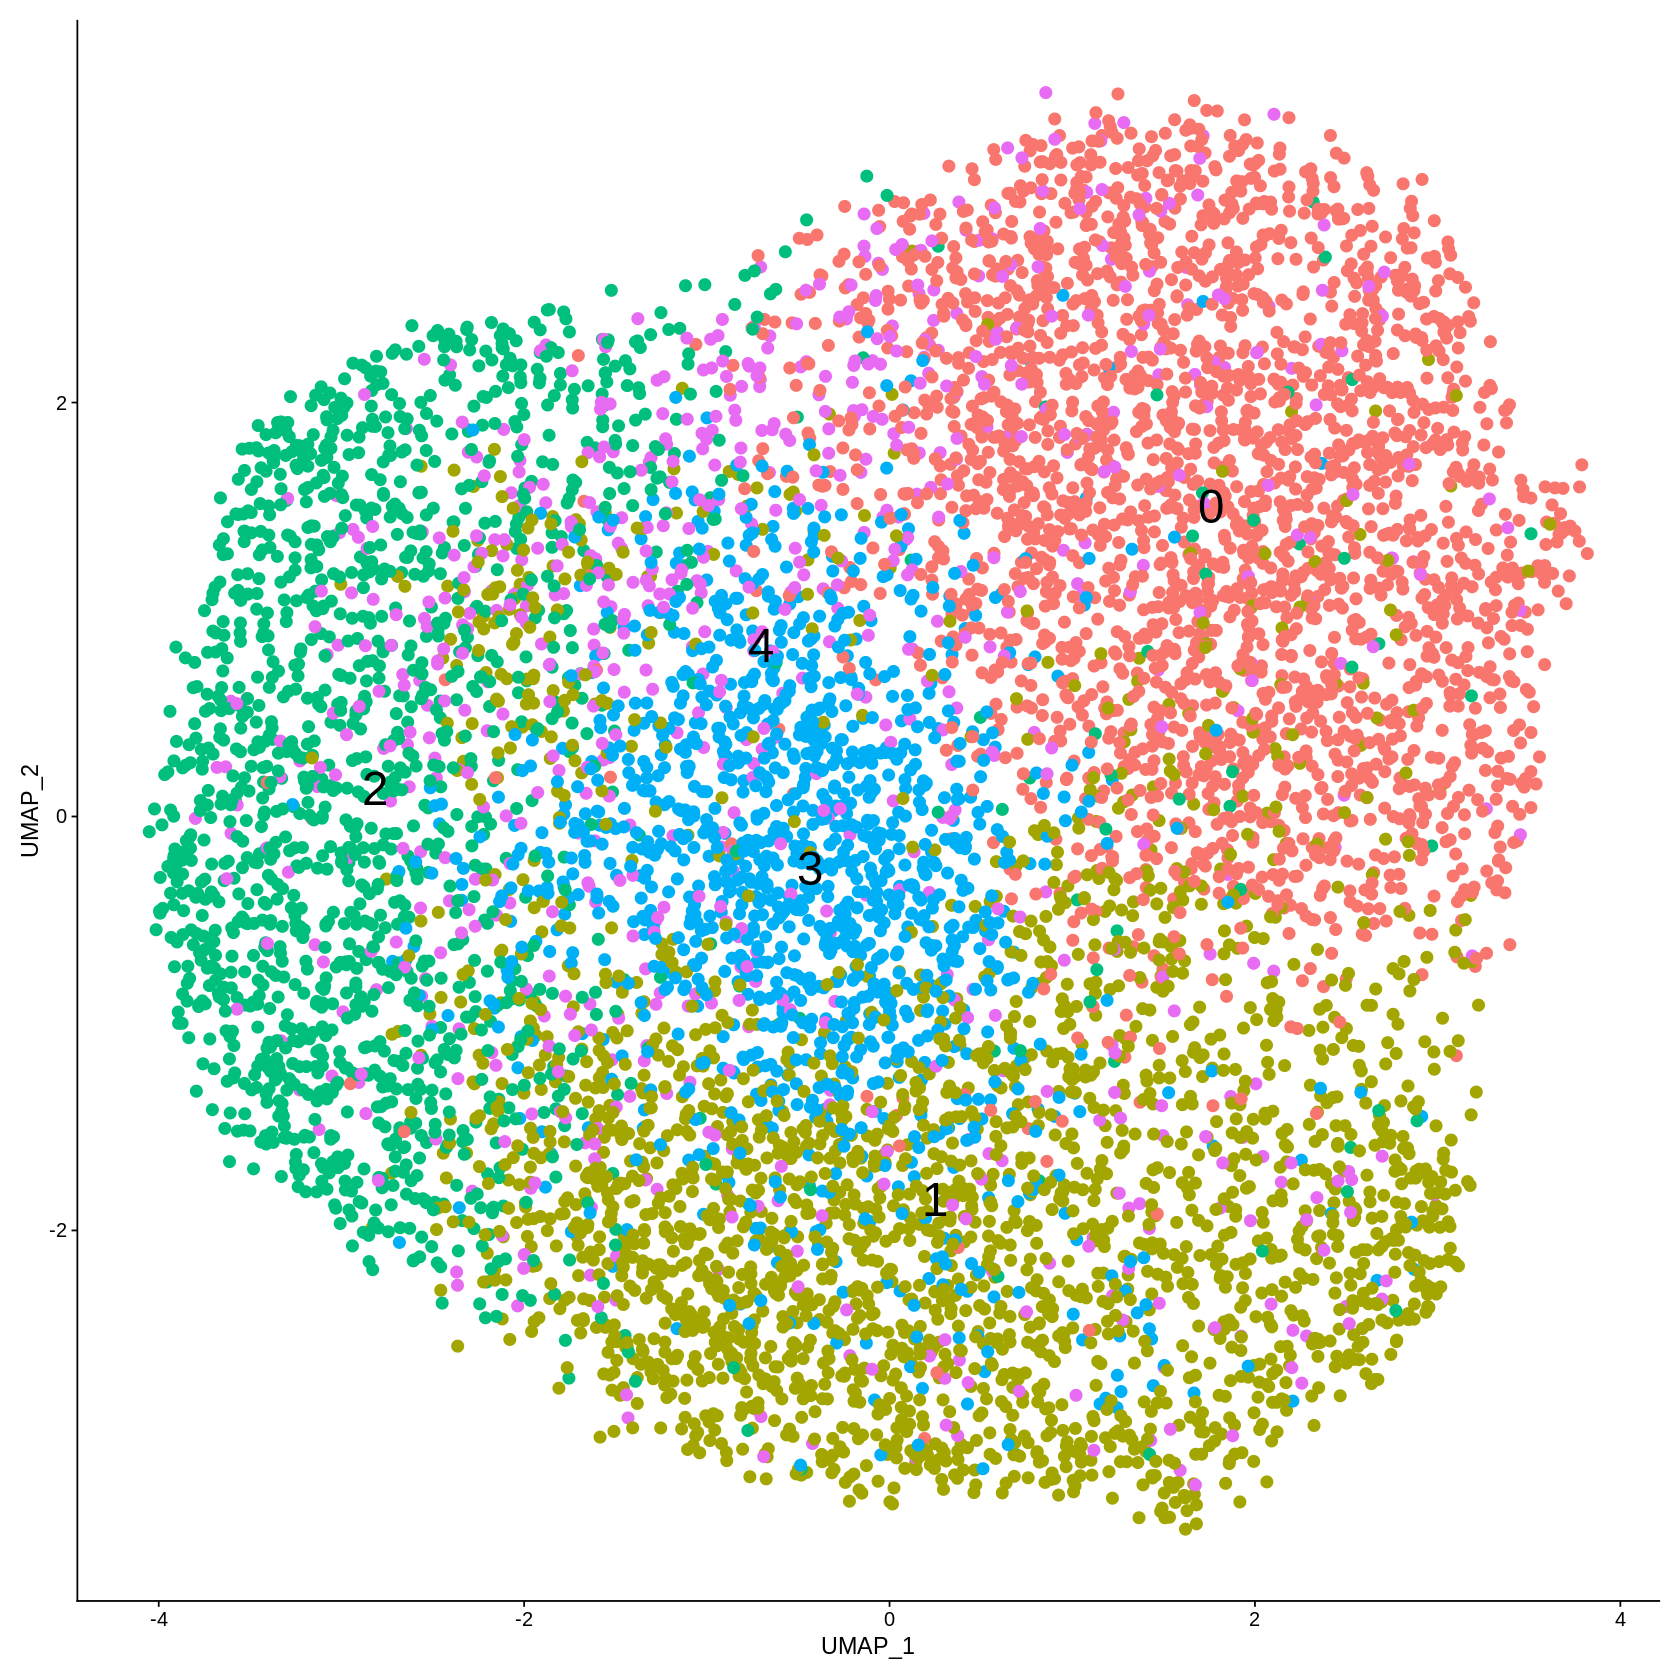

In [20]:
# plot UMAP
DimPlot(object = combined, 
        pt.size = 3, label.size = 10, 
        shuffle = TRUE, 
        label = TRUE) + NoLegend()

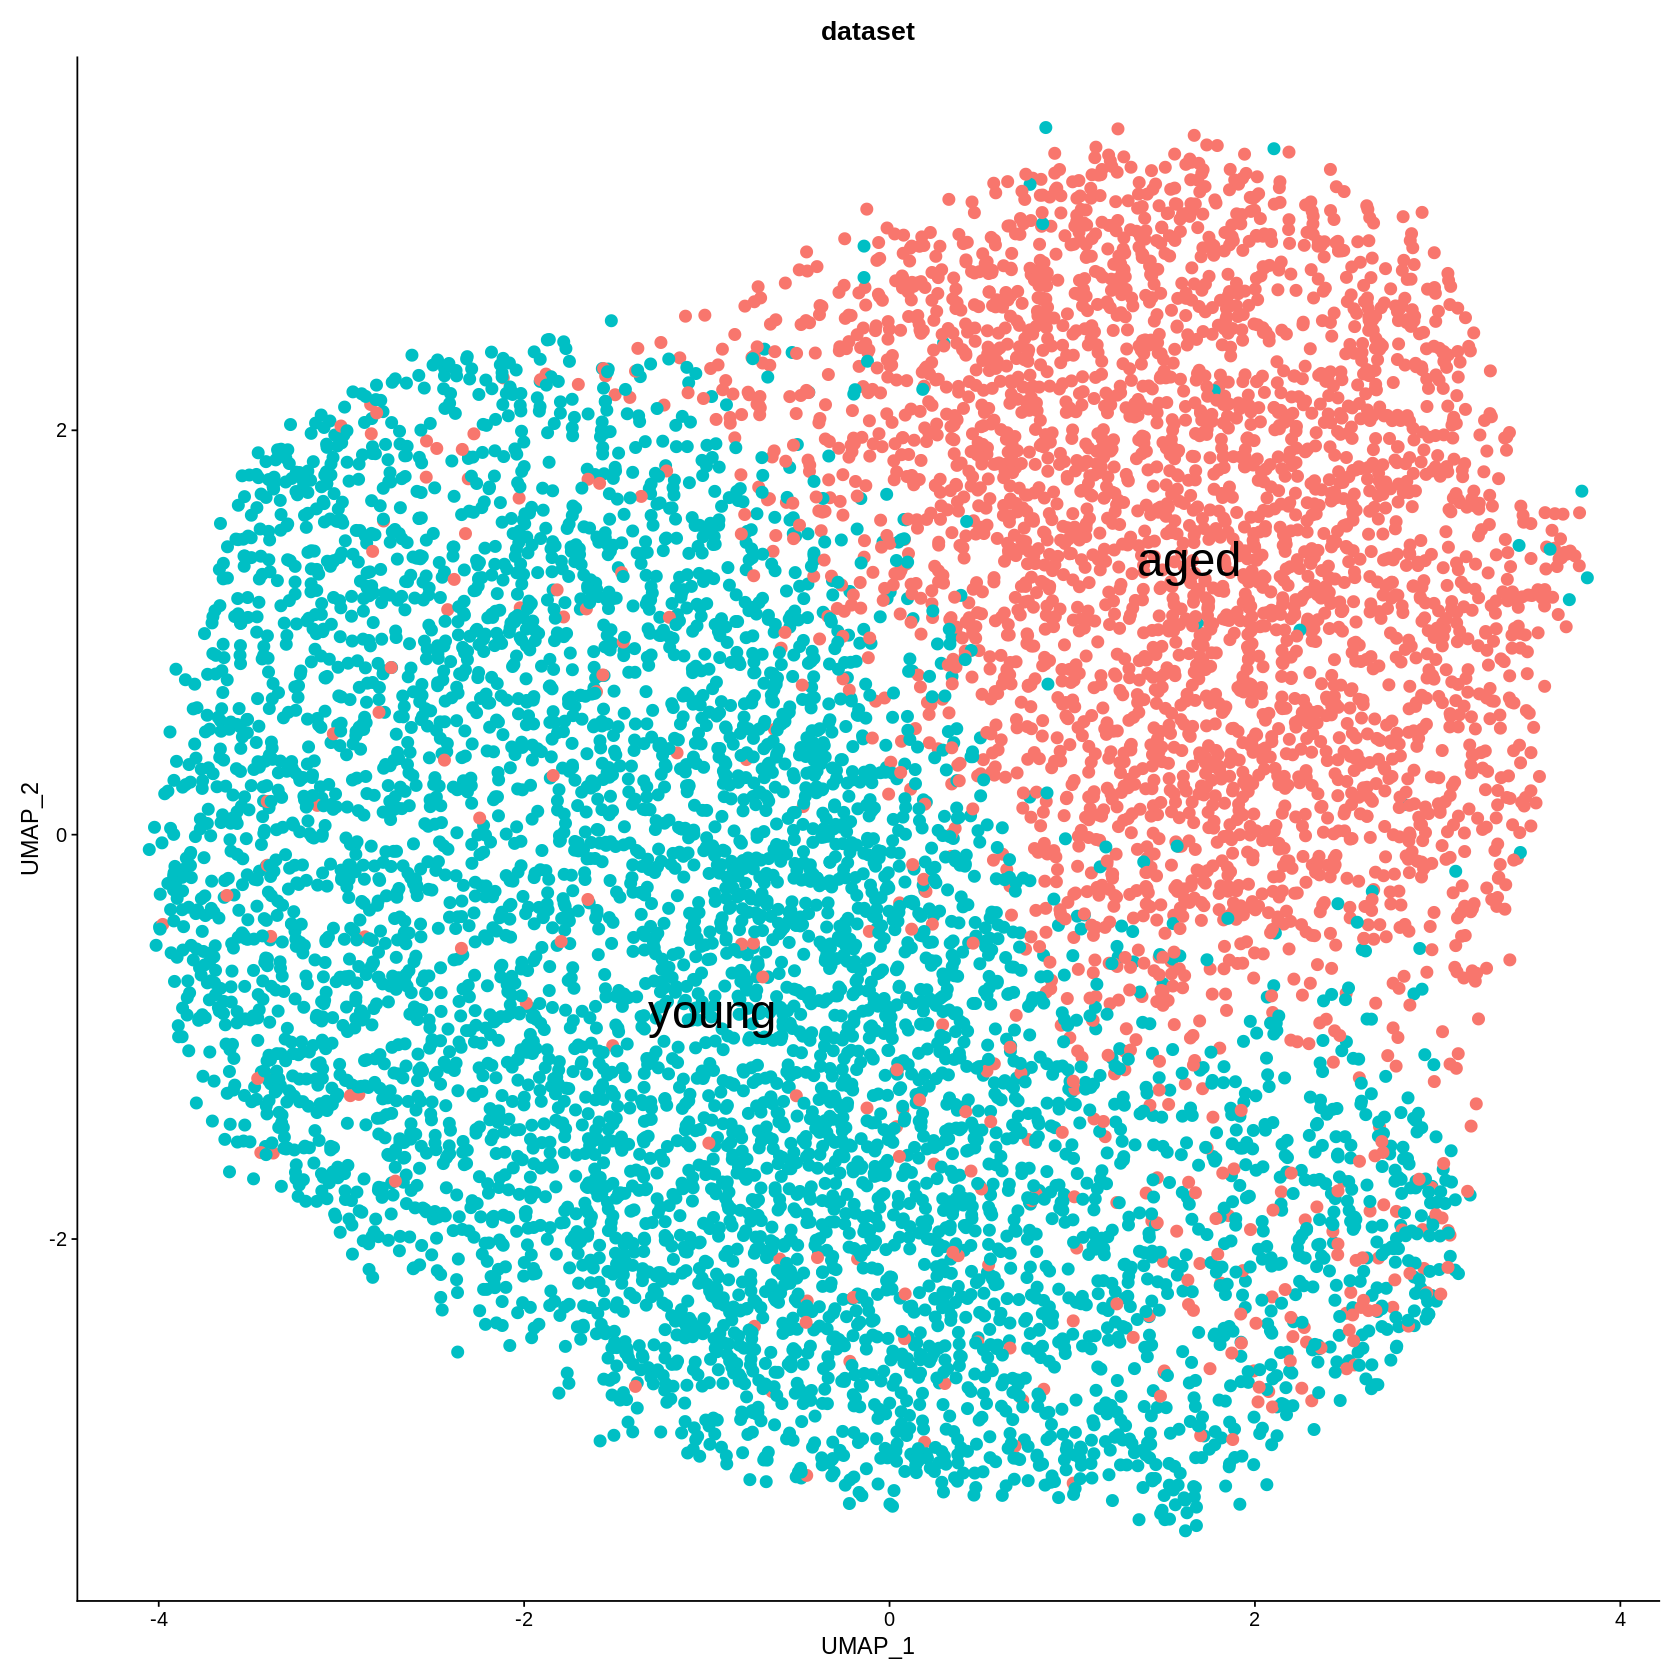

In [21]:
# UMAP colored by young vs aged
DimPlot(object = combined, 
        pt.size = 3, label.size = 10, 
        shuffle = TRUE, 
        label = TRUE, 
       group.by = "dataset") + NoLegend()

In [22]:
# aged vs young per cluster
table(combined$dataset, combined$ATAC_snn_res.0.8)

       
           0    1    2    3    4
  aged  2450  350   70  103  291
  young   58 2012 1462 1206  489

## Create estimated gene activity matrix

Signac allows the approximation of gene expression from chromatin accessibility data using the `GeneActivity()` function. This sums the fragments intersecting the gene body and promoter region of every gene in the genome for each cell, thus creating a "gene activity" matrix. This is a bit more interpretable than the list of accessible regions.

In [23]:
gene.activities <- GeneActivity(combined) # ~ 130s

gene.activities[1:10, 1:66]

Extracting gene coordinates

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

  [[ suppressing 66 column names 'young_AAACGAAAGTGATTAG-1', 'young_AAACGAAAGTTCAACC-1', 'young_AAACGAACAAATTGAG-1' ... ]]



10 x 66 sparse Matrix of class "dgCMatrix"
                                                                               
Hnf4g         . . . . . . . . . 1 . . . . . . . 1 . . . . . . . . . . . . . . .
Zfhx4         1 . . . . . . . . . . 1 . . . . 1 . . . 1 . . . . . . . . . . . .
Pex2          . . . . . . 1 . . . . 1 . . . . . 1 . . . . . . 1 . . . . . . . .
UBC           . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
1700008P02Rik . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Pkia          . . . . . 1 . . 1 . . . . . . . . . . . . . . . . . 1 . . . . . .
Zc2hc1a       . . 1 . . . . . 1 . . 1 . . . 1 . . . . . . . 1 . . . . . . . . .
Il7           . . . . . . . . . . . . . . . . 1 . . 1 . . . . 1 . 1 . . . 1 . .
1700010I02Rik . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Stmn2         . . . 1 . . . . . . . 1 . . . . . 1 . . . . . . . . . . 1 . . . .
                                                                             

In [24]:
# Explicitly close multisession workers by switching plan - otherwise NormalizeData below crashes
plan(sequential)
plan()

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: plan(sequential)

---
The gene activity can be considered a noisy approximation to scRNA-seq. We now add it to our Seurat object and normalize it as we would scRNA-seq data: for each cell, sum the activity of each gene and divide each gene activity by this total. Then multiply each gene entry by a scaling factor (in this case, the median of the cells' total gene activity). Finally, add a pseudocount and take the natural log.

In [25]:
# add the gene activity matrix to the Seurat object as a new assay and normalize it
combined[['RNA']] <- CreateAssayObject(counts = gene.activities)

combined <- NormalizeData(
  object = combined,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(combined$nCount_RNA)
) # ~3s

combined[['RNA']]

Assay data with 21821 features for 8491 cells
First 10 features:
 Hnf4g, Zfhx4, Pex2, UBC, 1700008P02Rik, Pkia, Zc2hc1a, Il7,
1700010I02Rik, Stmn2 

---
We can then make plots to visualize the gene actitivies of some canonical HSC marker genes.

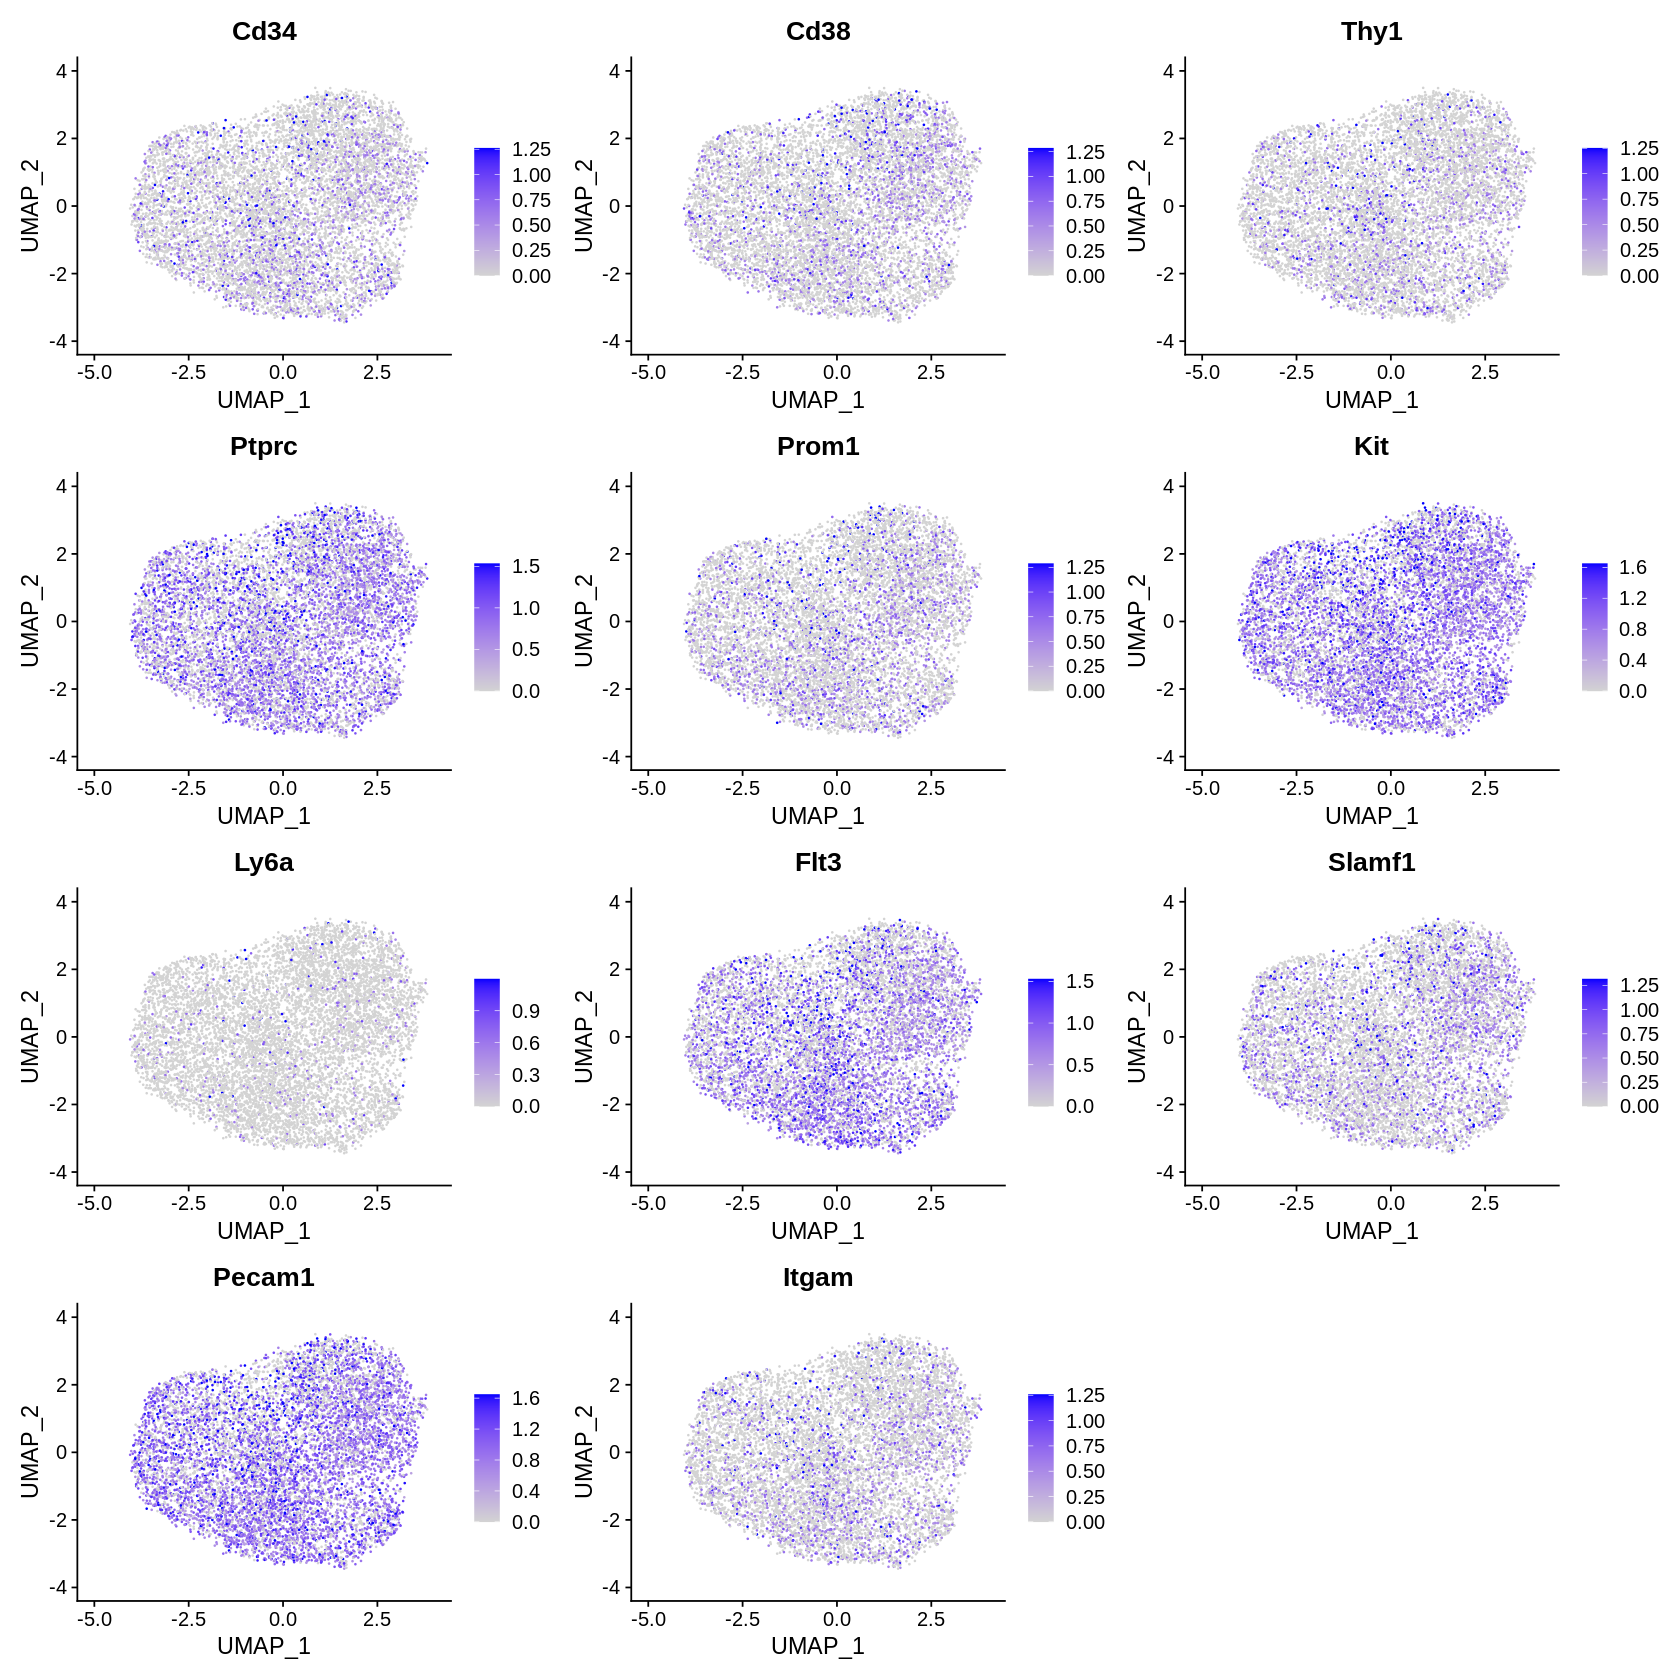

In [26]:
# visualize the activities of canonical marker genes
DefaultAssay(combined) <- 'RNA'

plot1 <- FeaturePlot(
          object = combined,
          features = c('Cd34', 'Cd38', 'Thy1', 'Ptprc', 
                       'Prom1', 'Kit', 'Ly6a', 'Flt3', 
                       'Slamf1', 'Pecam1', 'Itgam'),
          pt.size = 0.1,
          max.cutoff = 'q95',
          ncol = 3
        )
plot1

## Differentially accessible peaks

We can also try and answer the question: which peaks are differentially accessible between young and aged HSCs?

To do this, we first set the identity class of the dataset to the young vs aged column `dataset` and switch back to working with ATAC peaks instead of gene activities.

In [27]:
# change back to working with peaks instead of gene activities
Idents(combined) <- 'dataset'
DefaultAssay(combined) <- 'ATAC'

# find differential markers for the two identity classes (young vs aged)
da_peaks <- FindMarkers(
  object = combined,
  ident.1 = "young",
  ident.2 = "aged",
  test.use = 'LR', # use logistic regression for differential accessibility test
    min.pct = 0.05, # only consider peaks found in at least 5% of the cells of either of the two groups
  latent.vars = 'peak_region_fragments' # latent variable to mitigate effect of differential sequencing depth on result 
)

head(da_peaks)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
chr2-107231278-107232435 1.335238e-126 -6.785867  0.001 0.098 2.664267e-121
chr17-58643214-58645092  8.853645e-122 -3.606995  0.011 0.136 1.766612e-116
chr3-99112422-99115022   2.927811e-116 -3.288629  0.014 0.141 5.842007e-111
chr3-57509149-57513454   9.526055e-103 -3.046371  0.016 0.134  1.900781e-97
chr5-127537049-127538119  1.593758e-98 -4.565465  0.004 0.093  3.180105e-93
chr16-23841670-23845601   1.050065e-97 -2.375476  0.032 0.169  2.095247e-92

In [28]:
length(da_peaks)

[1] 5

In [29]:
length(da_peaks[da_peaks$p_val_adj < 0.001, ])

[1] 5

In [30]:
sum(da_peaks[da_peaks$p_val_adj < 0.001, ]$avg_log2FC > 0)

[1] 201

---
There are 9,288 peaks/regions that are differentially accessible between young and aged HSCs.

Filtering with an adjusted p-value cutoff of 0.001 reduces this to 1,521.

Of the 1,521, only 201 are more accessible on young than aged. The majority 85%+ are more accessible on the aged HSCs.

Let's visualize some of the differentially accessible regions.

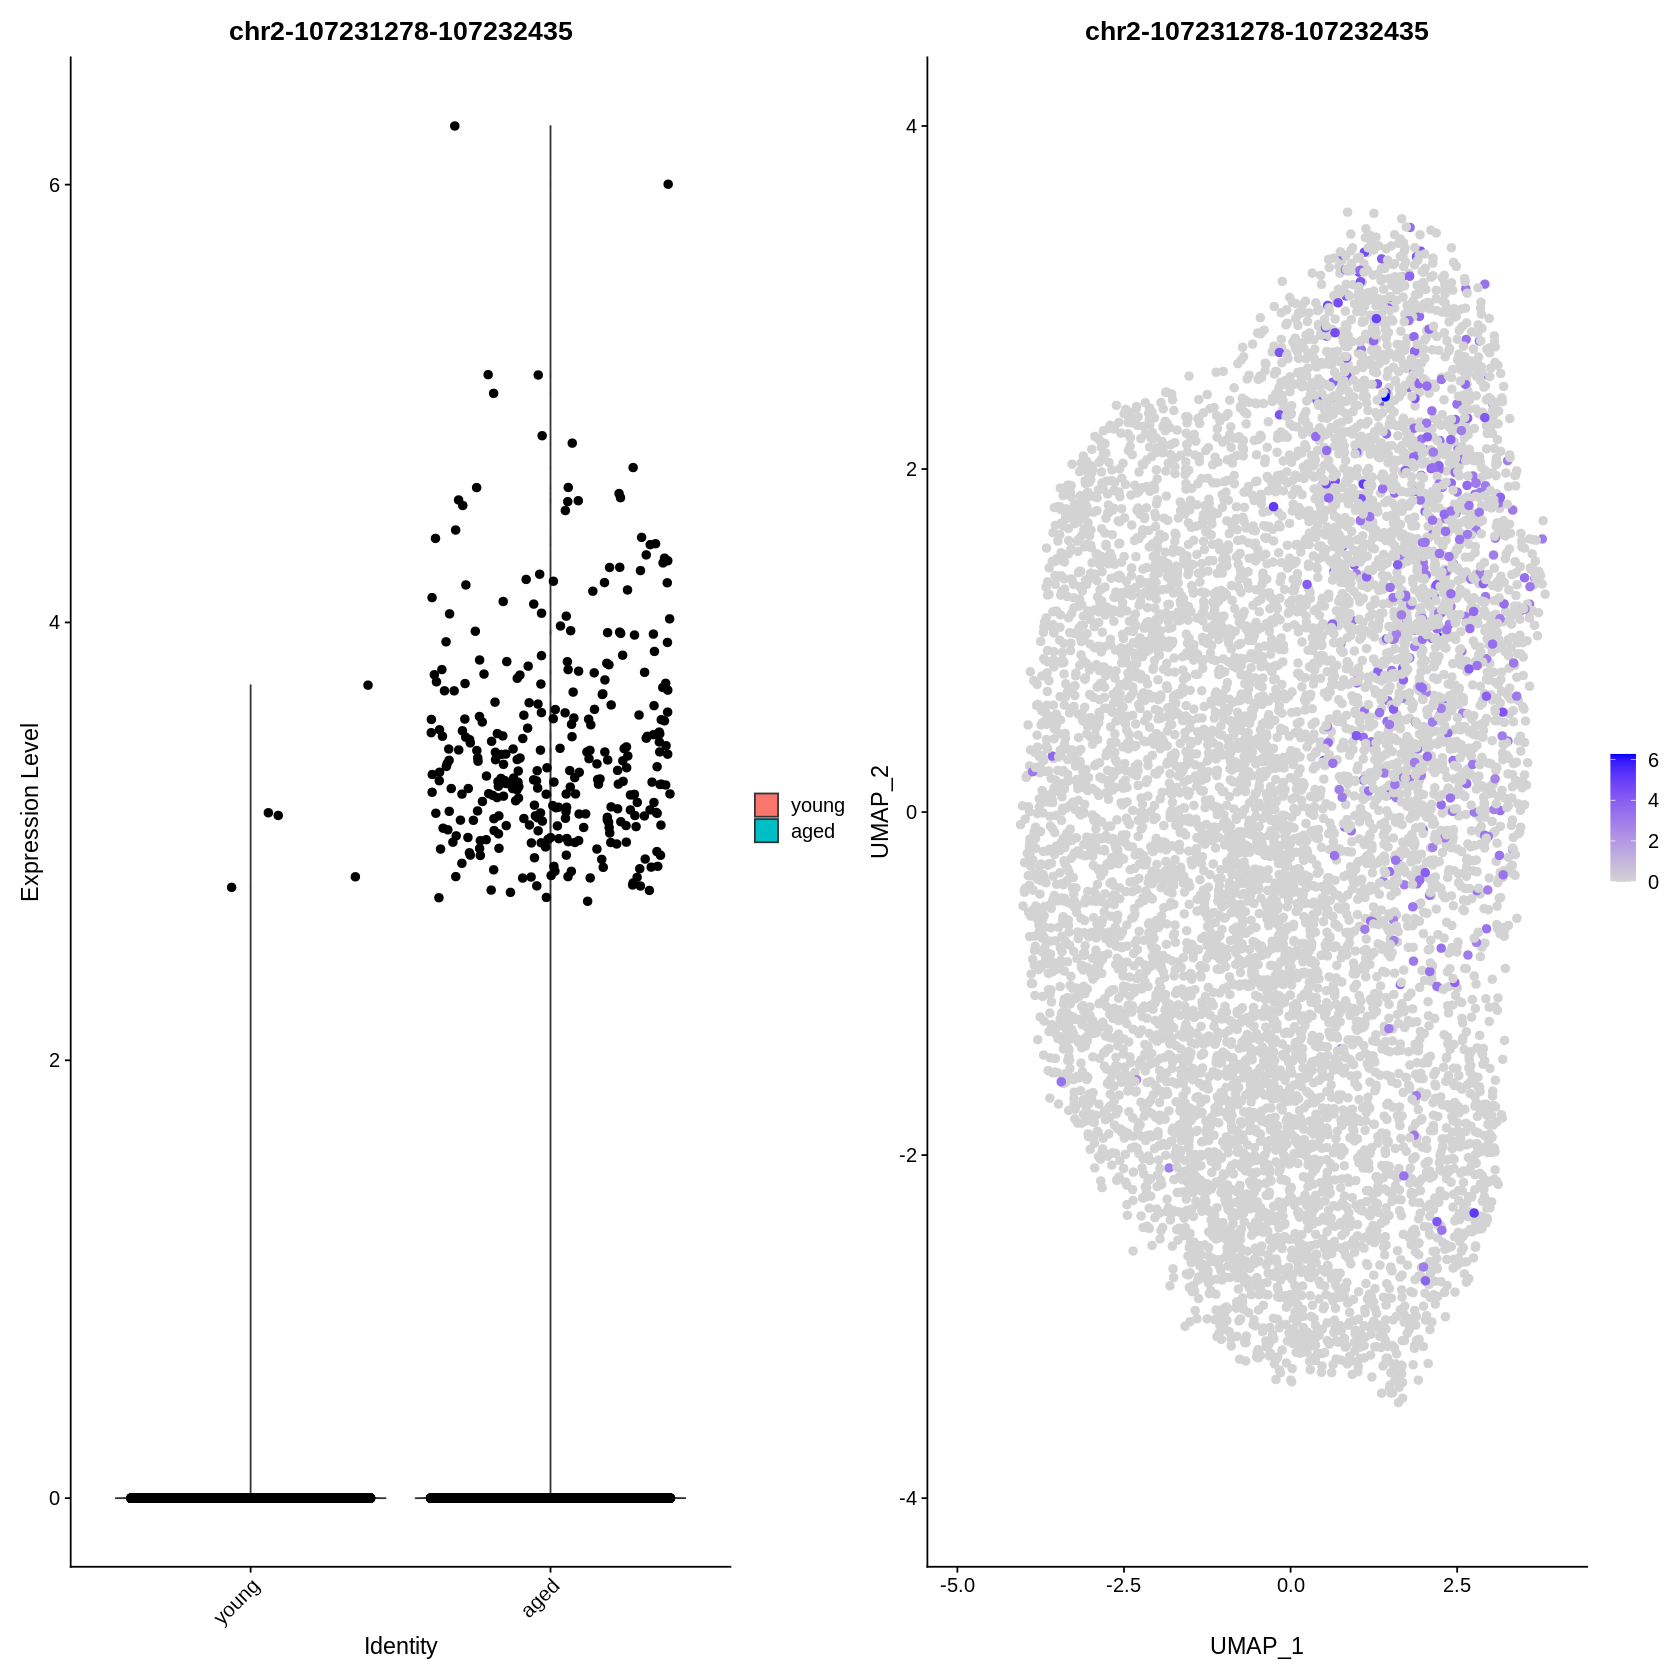

In [31]:
# visualization
plot1 <- VlnPlot(
  object = combined,
  features = rownames(da_peaks)[1],
  pt.size = 2,
  idents = c("young","aged")
)
plot2 <- FeaturePlot(
  object = combined,
  features = rownames(da_peaks)[1],
  pt.size = 2
)

plot1 | plot2

In [32]:
rownames(da_peaks)[1]

[1] "chr2-107231278-107232435"

In [33]:
# Sort the data frame by the absolute value of avg_log2FC
da_peaks_sorted <- da_peaks[order(-abs(da_peaks$avg_log2FC)), ]
head(da_peaks_sorted)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
chr2-107231278-107232435 1.335238e-126 -6.785867  0.001 0.098 2.664267e-121
chr7-72728445-72729718    7.153400e-61 -4.637761  0.002 0.057  1.427354e-55
chr5-127537049-127538119  1.593758e-98 -4.565465  0.004 0.093  3.180105e-93
chr7-70273640-70275132    1.336413e-93 -4.563807  0.003 0.089  2.666611e-88
chr6-81737474-81739083    2.203443e-82 -3.693893  0.007 0.091  4.396640e-77
chr15-44175698-44176493   6.949714e-50 -3.669477  0.004 0.055  1.386711e-44

In [34]:
da_peaks_sorted[da_peaks_sorted$avg_log2FC > 0, ] %>% head

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
chr19-6290930-6294154    1.310608e-48 2.060877   0.100 0.025 2.615121e-43
chr5-113775874-113777556 2.357445e-46 2.031687   0.096 0.024 4.703927e-41
chr19-41328333-41329456  1.942613e-19 1.655927   0.050 0.017 3.876192e-14
chr14-53045081-53046009  1.439582e-20 1.552094   0.059 0.021 2.872469e-15
chr7-58836480-58837963   2.659452e-20 1.548195   0.059 0.021 5.306538e-15
chr10-78405547-78407182  3.392998e-17 1.509009   0.052 0.018 6.770219e-12

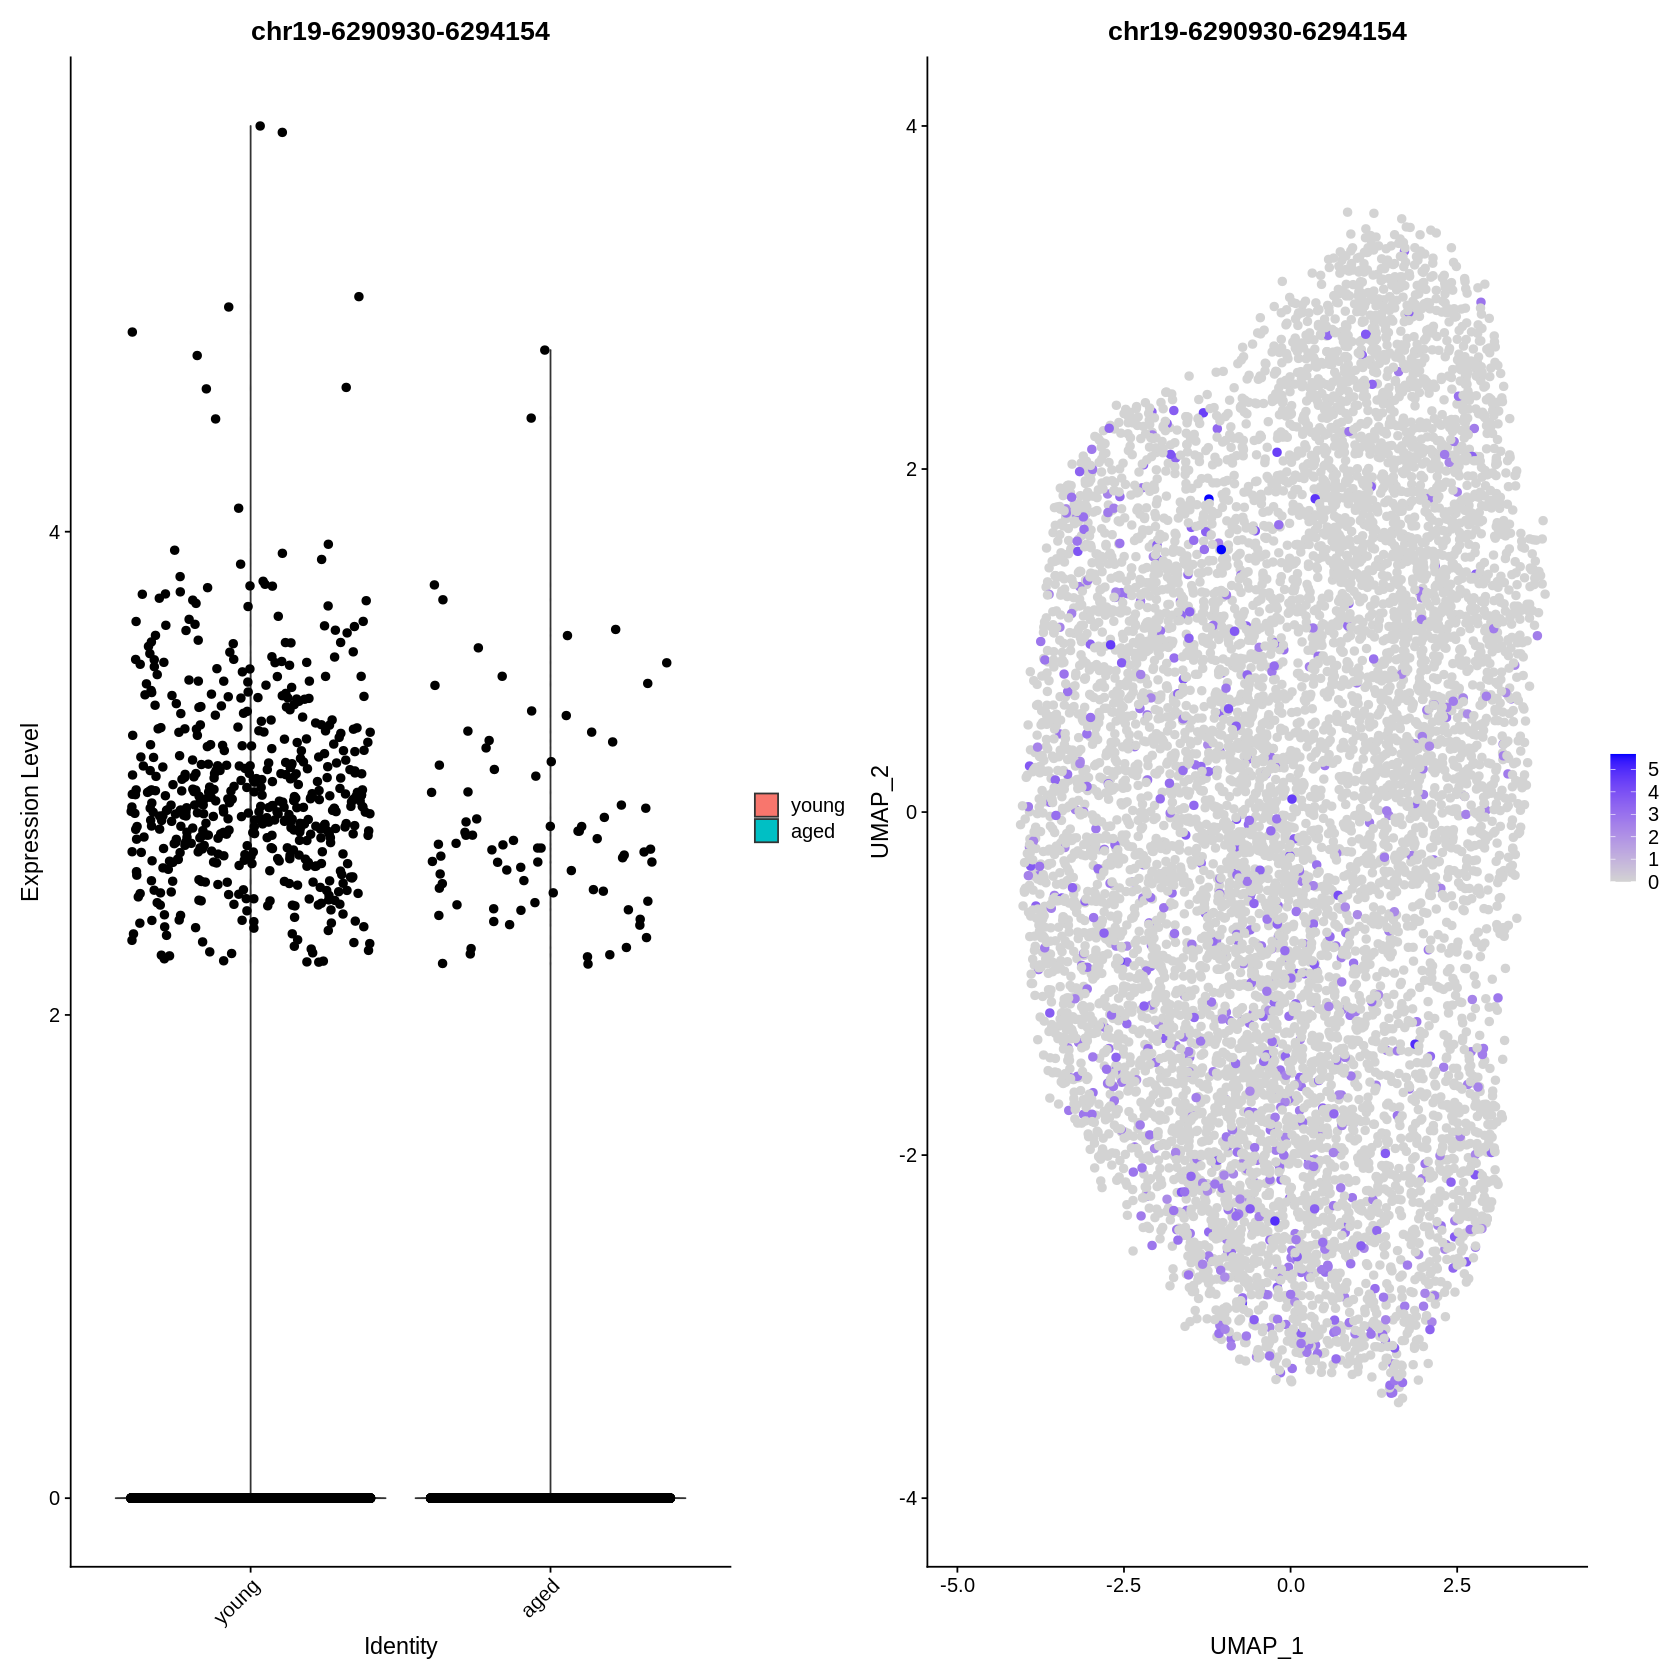

In [35]:
# visualization
plot1 <- VlnPlot(
  object = combined,
  features = 'chr19-6290930-6294154',
  pt.size = 2,
  idents = c("young","aged")
)
plot2 <- FeaturePlot(
  object = combined,
  features = 'chr19-6290930-6294154',
  pt.size = 2
)

plot1 | plot2

### Closest feature (gene)

"Peak coordinates can be difficult to interpret alone. We can find the closest gene to each of these peaks using the `ClosestFeature()` function. We could follow up this result further by doing gene ontology enrichment analysis on the gene sets returned by `ClosestFeature()`."

In [36]:
da_peaks_closest_feature <- ClosestFeature(combined, 
                                          regions = rownames(da_peaks))
head(da_peaks_closest_feature)

tx_id              gene_name gene_id           
ENSMUSE00000442043 ENSMUST00000037012 Kcna4     ENSMUSG00000042604
ENSMUST00000076038 ENSMUST00000076038 Cntnap5c  ENSMUSG00000038048
ENSMUSE00000745850 ENSMUST00000004343 Wars2     ENSMUSG00000004233
ENSMUST00000120977 ENSMUST00000120977 Wwtr1     ENSMUSG00000027803
ENSMUST00000119026 ENSMUST00000119026 Tmem132c  ENSMUSG00000034324
ENSMUST00000004480 ENSMUST00000004480 Sst       ENSMUSG00000004366
                   gene_biotype   type closest_region          
ENSMUSE00000442043 protein_coding exon chr2-107290639-107291071
ENSMUST00000076038 protein_coding cds  chr17-58410146-58410342 
ENSMUSE00000745850 protein_coding exon chr3-99141068-99141188  
ENSMUST00000120977 protein_coding gap  chr3-57501869-57574822  
ENSMUST00000119026 protein_coding gap  chr5-127536502-127551502
ENSMUST00000004480 protein_coding utr  chr16-23889581-23889728 
                   query_region             distance
ENSMUSE00000442043 chr2-107231278-107232435  58203  
ENSMUST00000076038 chr17-58643214-58645092  232871  
ENSMUSE00000745850 chr3-99112422-99115022    26045  
ENSMUST00000120977 chr3-57509149-57513454        0  
ENSMUST00000119026 chr5-127537049-127538119      0  
ENSMUST00000004480 chr16-23841670-23845601   43979

In [37]:
da_peaks_closest_feature[da_peaks_closest_feature$distance == 0, ] %>% head(n = 25)

tx_id              gene_name gene_id           
ENSMUST00000120977   ENSMUST00000120977 Wwtr1     ENSMUSG00000027803
ENSMUST00000119026   ENSMUST00000119026 Tmem132c  ENSMUSG00000034324
ENSMUST00000120061   ENSMUST00000120061 Rbfox3    ENSMUSG00000025576
ENSMUST00000087638   ENSMUST00000087638 Aldh1a1   ENSMUSG00000053279
ENSMUST00000148850   ENSMUST00000148850 Arhgap26  ENSMUSG00000036452
ENSMUST00000175681   ENSMUST00000175681 Kcnb2     ENSMUSG00000092083
ENSMUST00000120555   ENSMUST00000120555 Dpp6      ENSMUSG00000061576
ENSMUST00000183169   ENSMUST00000183169 Ank3      ENSMUSG00000069601
ENSMUST00000080665   ENSMUST00000080665 Dnah9     ENSMUSG00000056752
ENSMUST00000091514   ENSMUST00000091514 Srd5a1    ENSMUSG00000021594
ENSMUST00000183850   ENSMUST00000183850 Kcnn2     ENSMUSG00000054477
ENSMUST00000184955   ENSMUST00000184955 Nav2      ENSMUSG00000052512
ENSMUST00000179393   ENSMUST00000179393 Oxr1      ENSMUSG00000022307
ENSMUST00000131127   ENSMUST00000131127 Pcnxl2    ENSMUSG00000060212
ENSMUST00000169668   ENSMUST00000169668 Man2a1    ENSMUSG00000024085
ENSMUST00000098438   ENSMUST00000098438 Mrgpra1   ENSMUSG00000050650
ENSMUST00000177378   ENSMUST00000177378 Ros1      ENSMUSG00000019893
ENSMUST00000051572   ENSMUST00000051572 Sdpr      ENSMUSG00000045954
ENSMUST00000099292   ENSMUST00000099292 Gm5535    ENSMUSG00000074758
ENSMUST00000166909   ENSMUST00000166909 Men1      ENSMUSG00000024947
ENSMUST00000125450   ENSMUST00000125450 Zfp407    ENSMUSG00000048410
ENSMUST00000175681.1 ENSMUST00000175681 Kcnb2     ENSMUSG00000092083
ENSMUST00000185104   ENSMUST00000185104 Tmem132b  ENSMUSG00000070498
ENSMUST00000120977.1 ENSMUST00000120977 Wwtr1     ENSMUSG00000027803
ENSMUST00000030738   ENSMUST00000030738 Utp11l    ENSMUSG00000028907
                     gene_biotype   type closest_region           
ENSMUST00000120977   protein_coding gap  chr3-57501869-57574822   
ENSMUST00000119026   protein_coding gap  chr5-127536502-127551502 
ENSMUST00000120061   protein_coding gap  chr11-118513405-118610158
ENSMUST00000087638   protein_coding cds  chr19-20602012-20602077  
ENSMUST00000148850   protein_coding gap  chr18-38676806-38933792  
ENSMUST00000175681   protein_coding gap  chr1-15313031-15709484   
ENSMUST00000120555   protein_coding cds  chr5-26905238-26905288   
ENSMUST00000183169   protein_coding gap  chr10-69534285-69808415  
ENSMUST00000080665   protein_coding cds  chr11-66168057-66168467  
ENSMUST00000091514   protein_coding cds  chr13-69594916-69595017  
ENSMUST00000183850   protein_coding cds  chr18-45561221-45561316  
ENSMUST00000184955   protein_coding gap  chr7-49304559-49362097   
ENSMUST00000179393   protein_coding cds  chr15-41825890-41826052  
ENSMUST00000131127   protein_coding cds  chr8-125839584-125839693 
ENSMUST00000169668   protein_coding gap  chr17-64714713-64731203  
ENSMUST00000098438   protein_coding gap  chr7-47335919-47354196   
ENSMUST00000177378   protein_coding gap  chr10-52130987-52142139  
ENSMUST00000051572   protein_coding cds  chr1-51289386-51289868   
ENSMUST00000099292   lincRNA        gap  chr2-144179149-144189140 
ENSMUST00000166909   protein_coding cds  chr19-6335461-6335614    
ENSMUST00000125450   protein_coding gap  chr18-84128354-84552869  
ENSMUST00000175681.1 protein_coding utr  chr1-15287254-15287484   
ENSMUST00000185104   protein_coding gap  chr5-125531994-125622460 
ENSMUST00000120977.1 protein_coding gap  chr3-57501869-57574822   
ENSMUST00000030738   protein_coding cds  chr4-124686089-124686150 
                     query_region              distance
ENSMUST00000120977   chr3-57509149-57513454    0       
ENSMUST00000119026   chr5-127537049-127538119  0       
ENSMUST00000120061   chr11-118602840-118605327 0       
ENSMUST00000087638   chr19-20599880-20607776   0       
ENSMUST00000148850   chr18-38689783-38691471   0       
ENSMUST00000175681   chr1-15677637-15680698    0       
ENSMUST00000120555   chr5-26903642-26905903    0       
ENSMUST00000183169   chr10-69611392-6

## Plot genomic regions

"We can plot the frequency of Tn5 integration across regions of the genome for cells grouped by cluster, cell type, or any other metadata stored in the object for any genomic region using the `CoveragePlot()` function. These represent pseudo-bulk accessibility tracks, where signal from all cells within a group have been averaged together to visualize the DNA accessibility in a region. Alongside these accessibility tracks we can visualize other important information including gene annotation, peak coordinates, and genomic links."

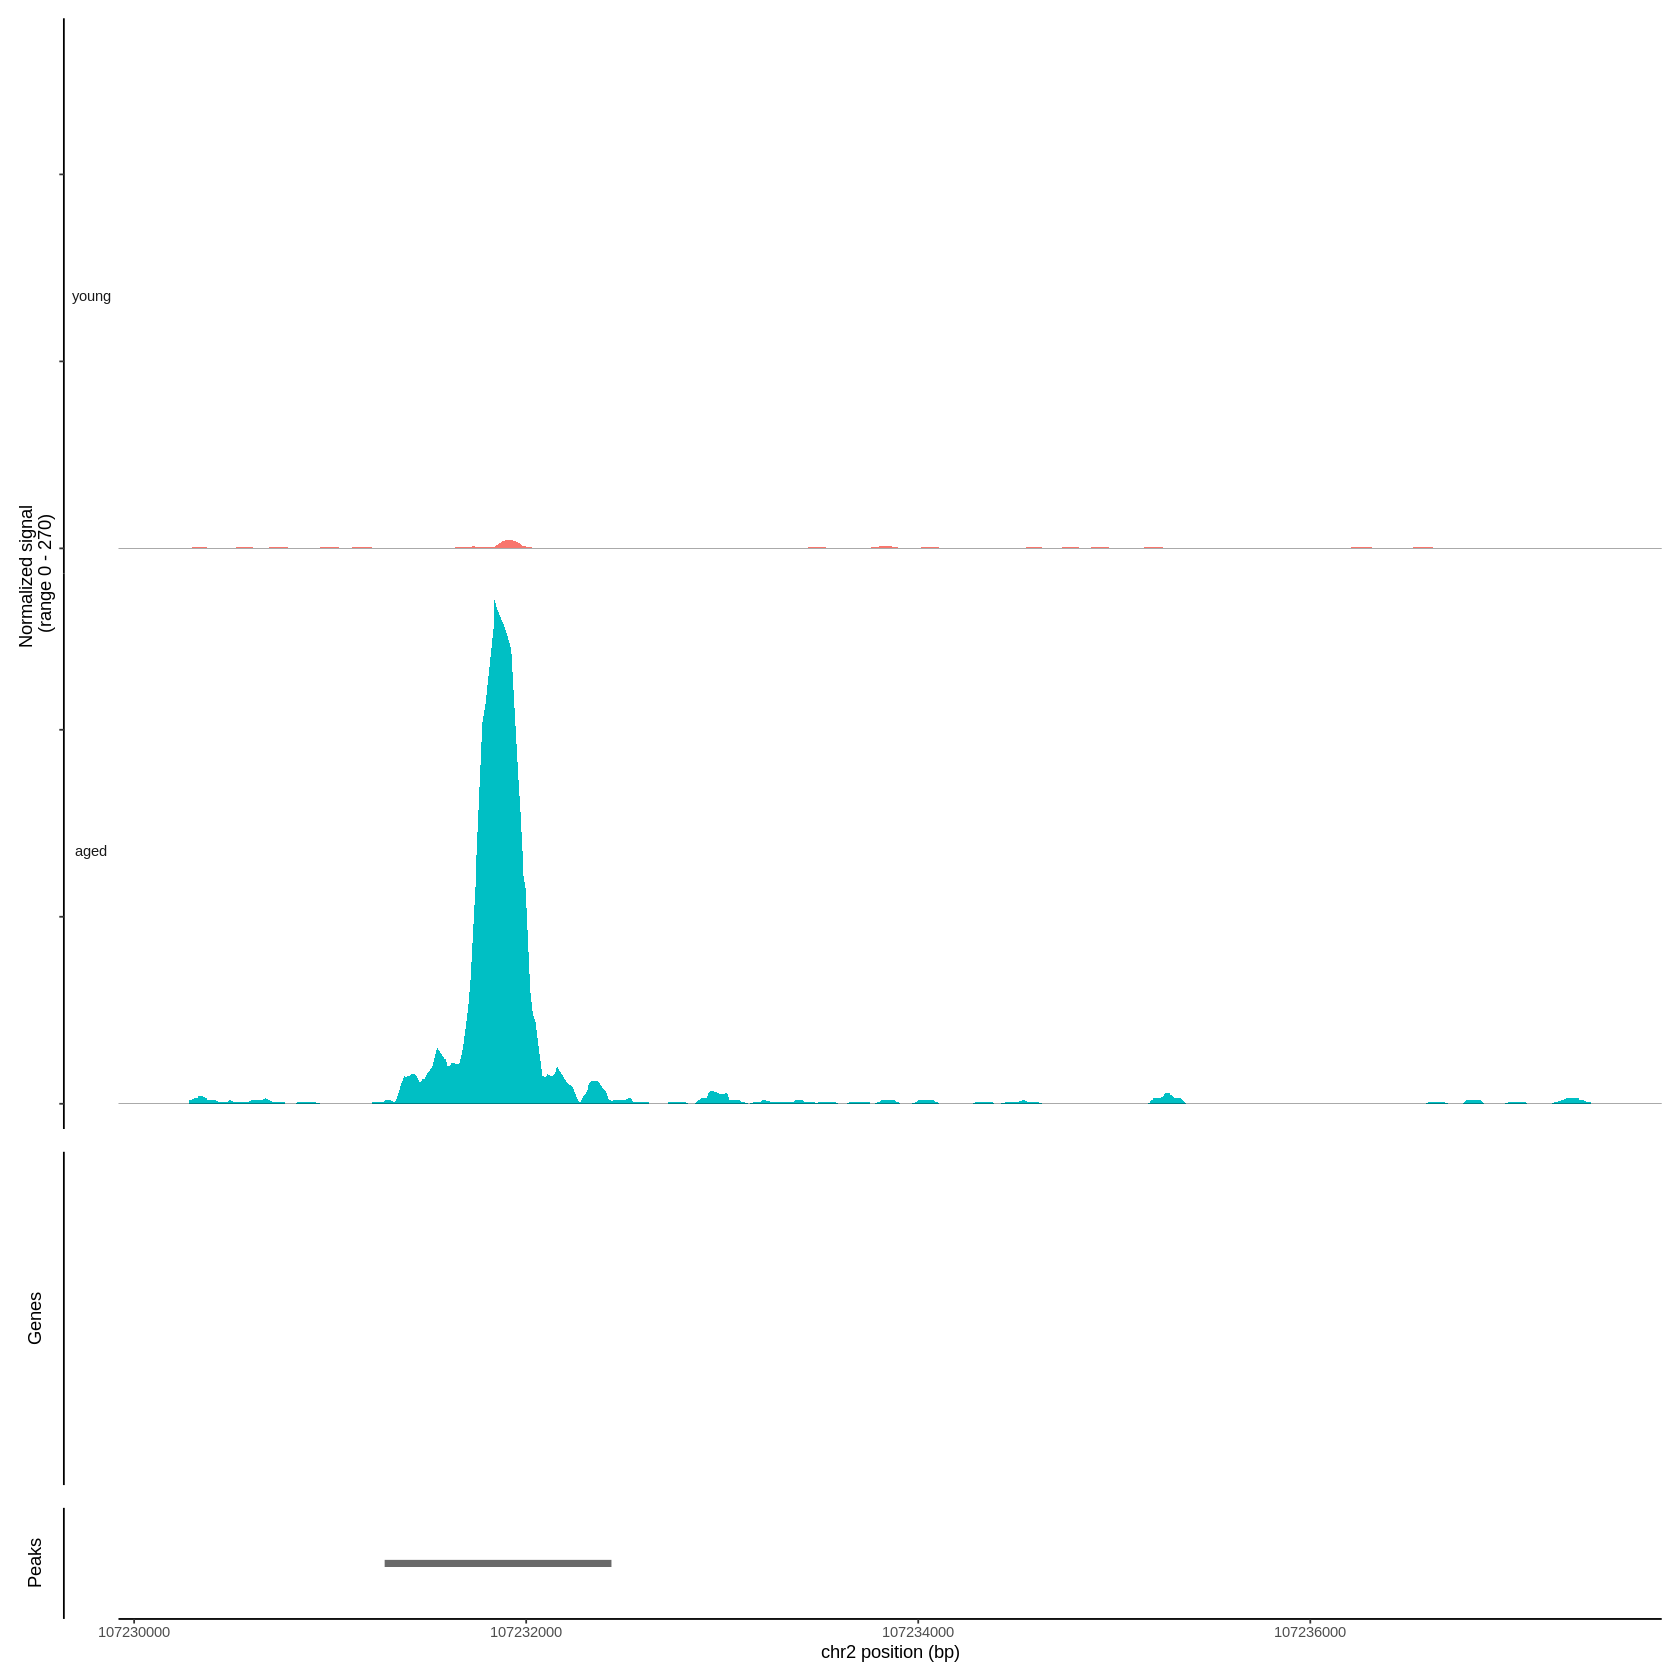

In [38]:
CoveragePlot(
  object = combined,
  region = rownames(da_peaks)[1],
  extend.upstream = 1000,
  extend.downstream = 5000
)

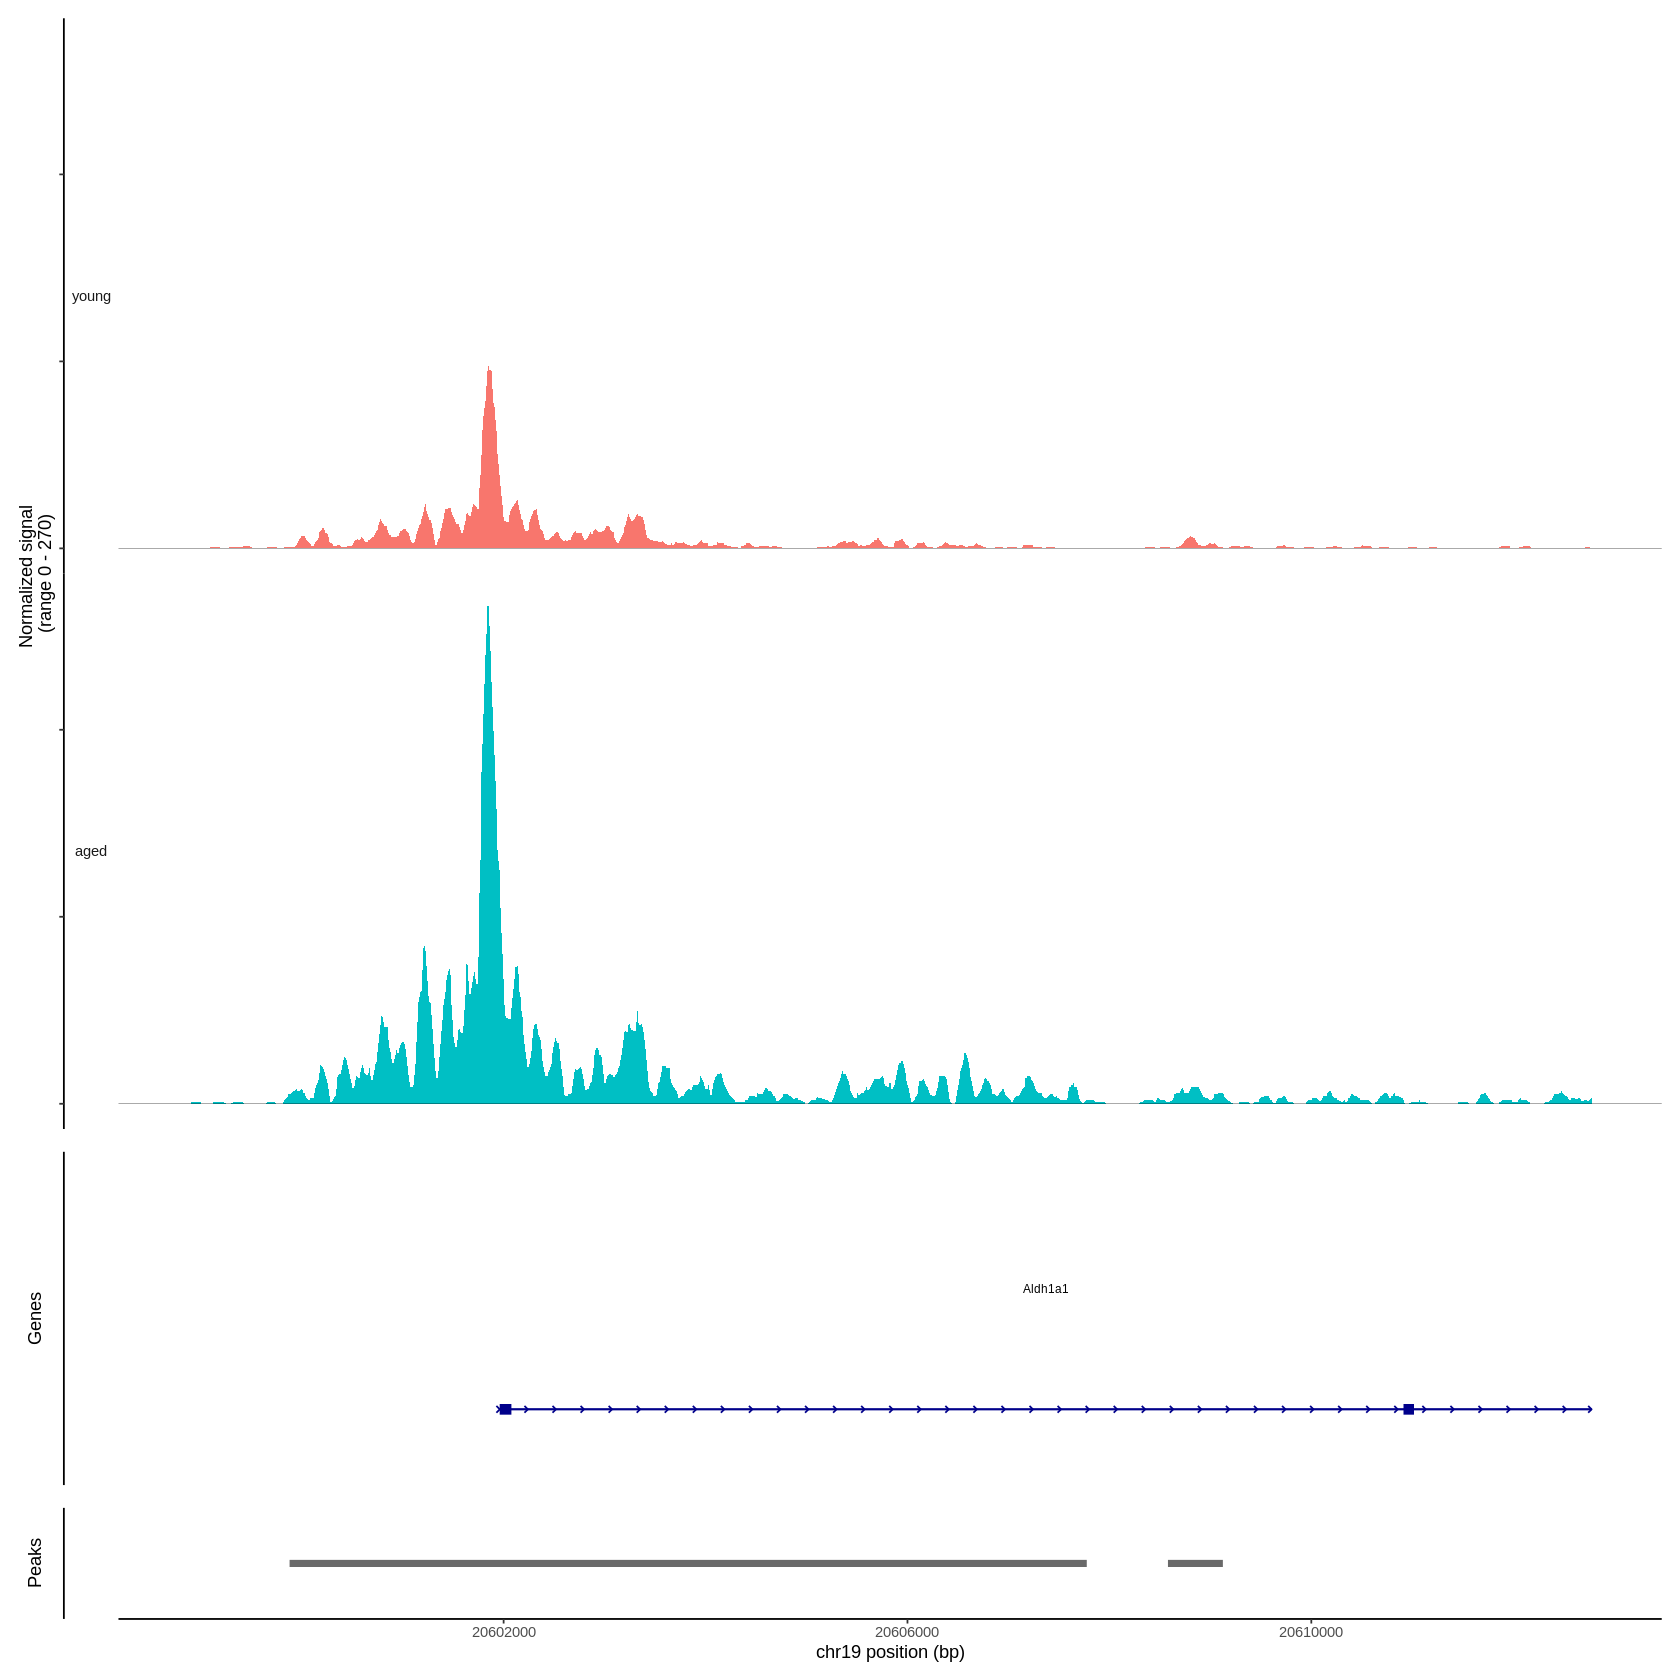

In [39]:
CoveragePlot(
  object = combined,
  region = "chr19-20599880-20607776",
  extend.upstream = 1000,
  extend.downstream = 5000
)

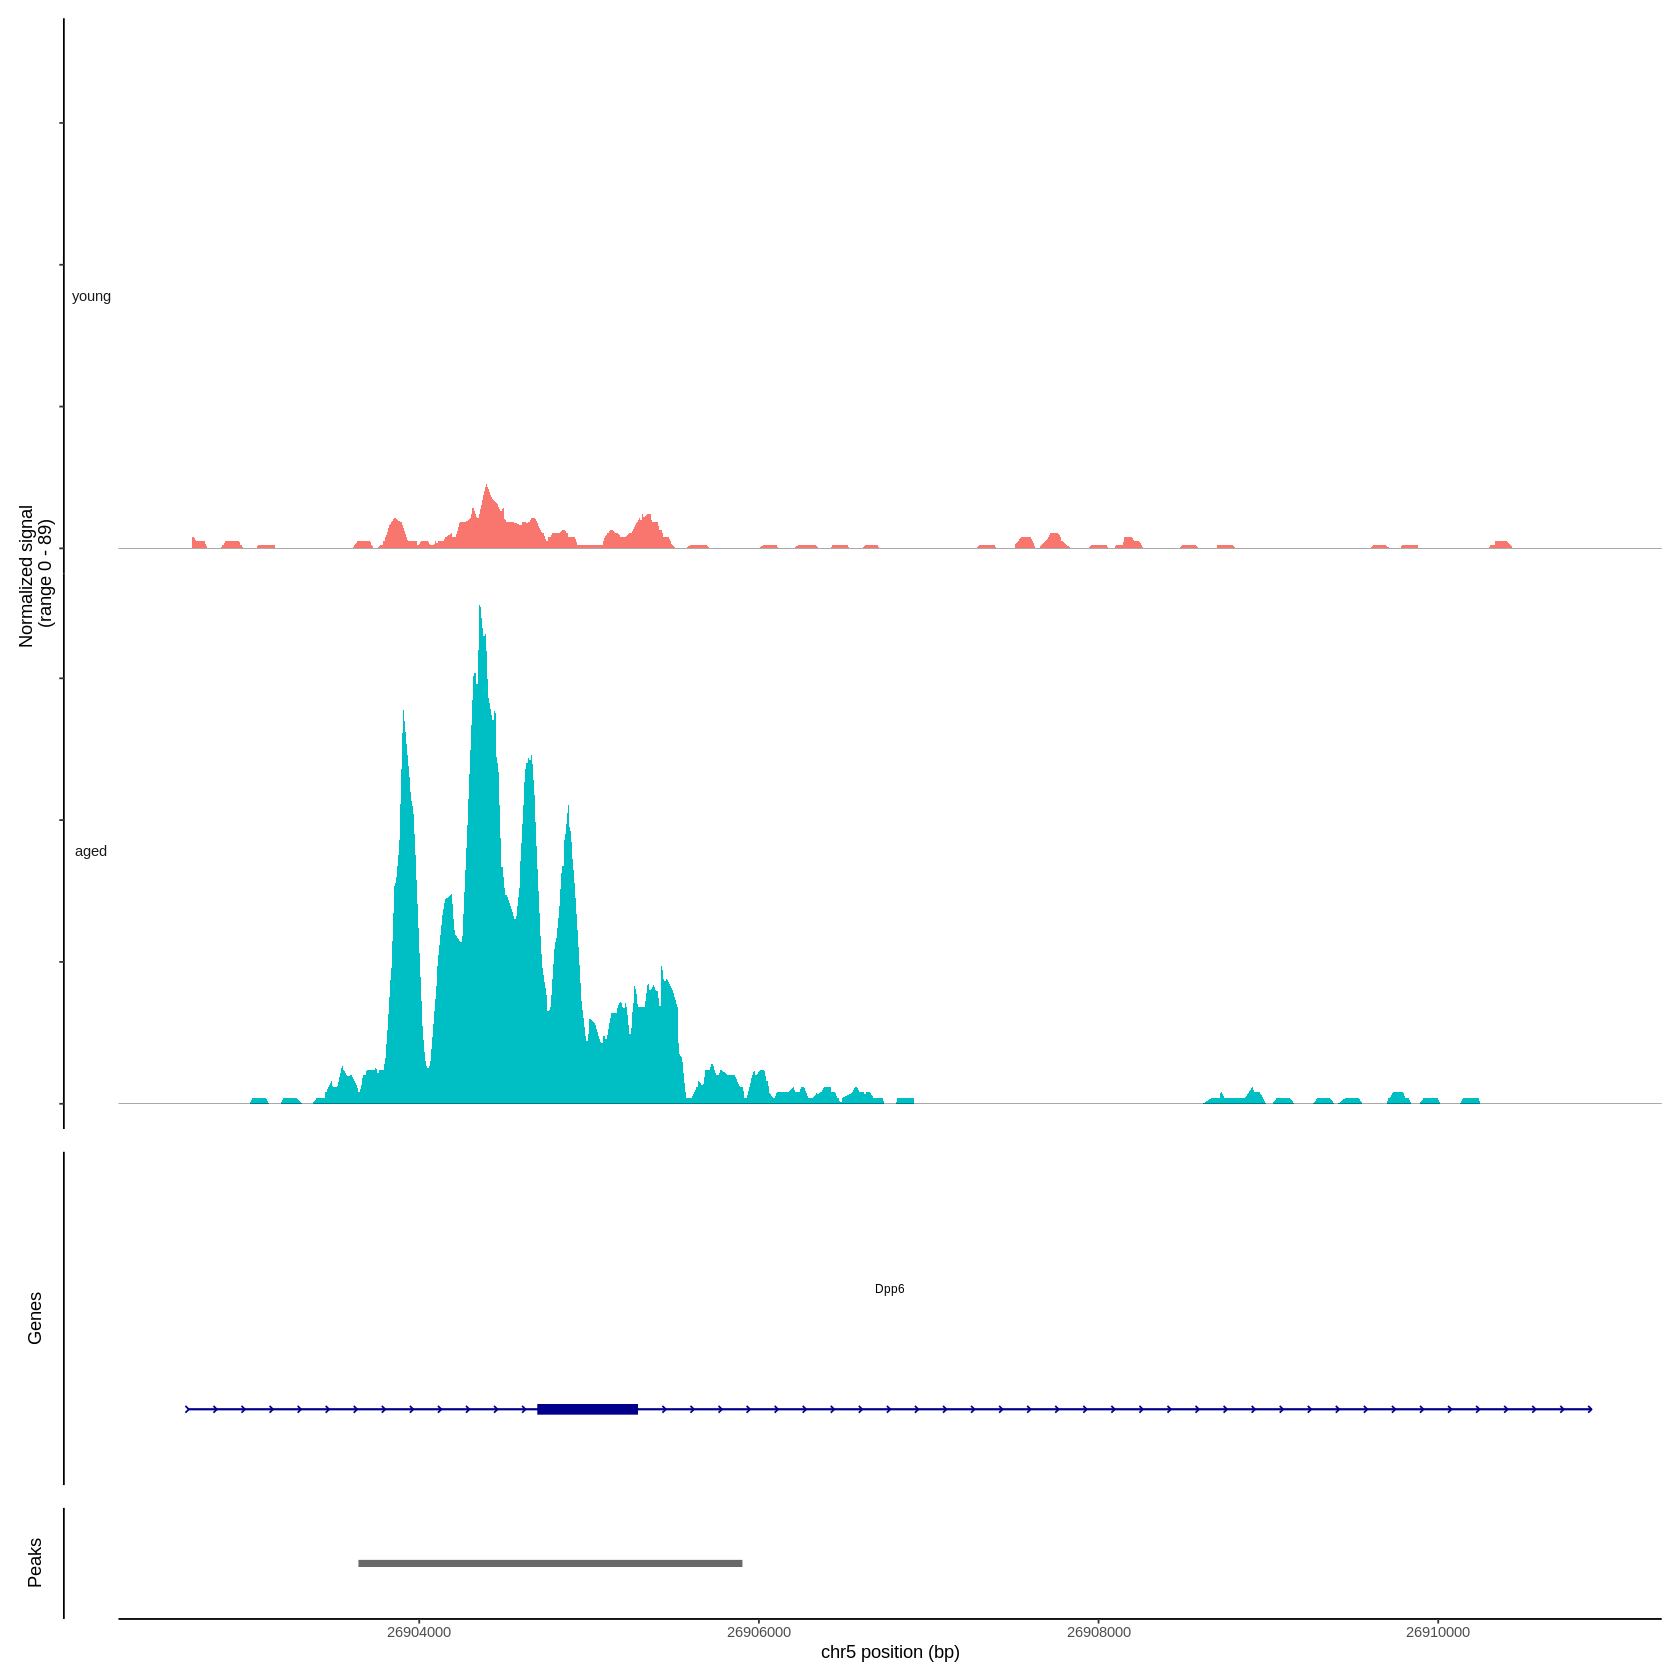

In [40]:
CoveragePlot(
  object = combined,
  region = "chr5-26903642-26905903",
  extend.upstream = 1000,
  extend.downstream = 5000
)

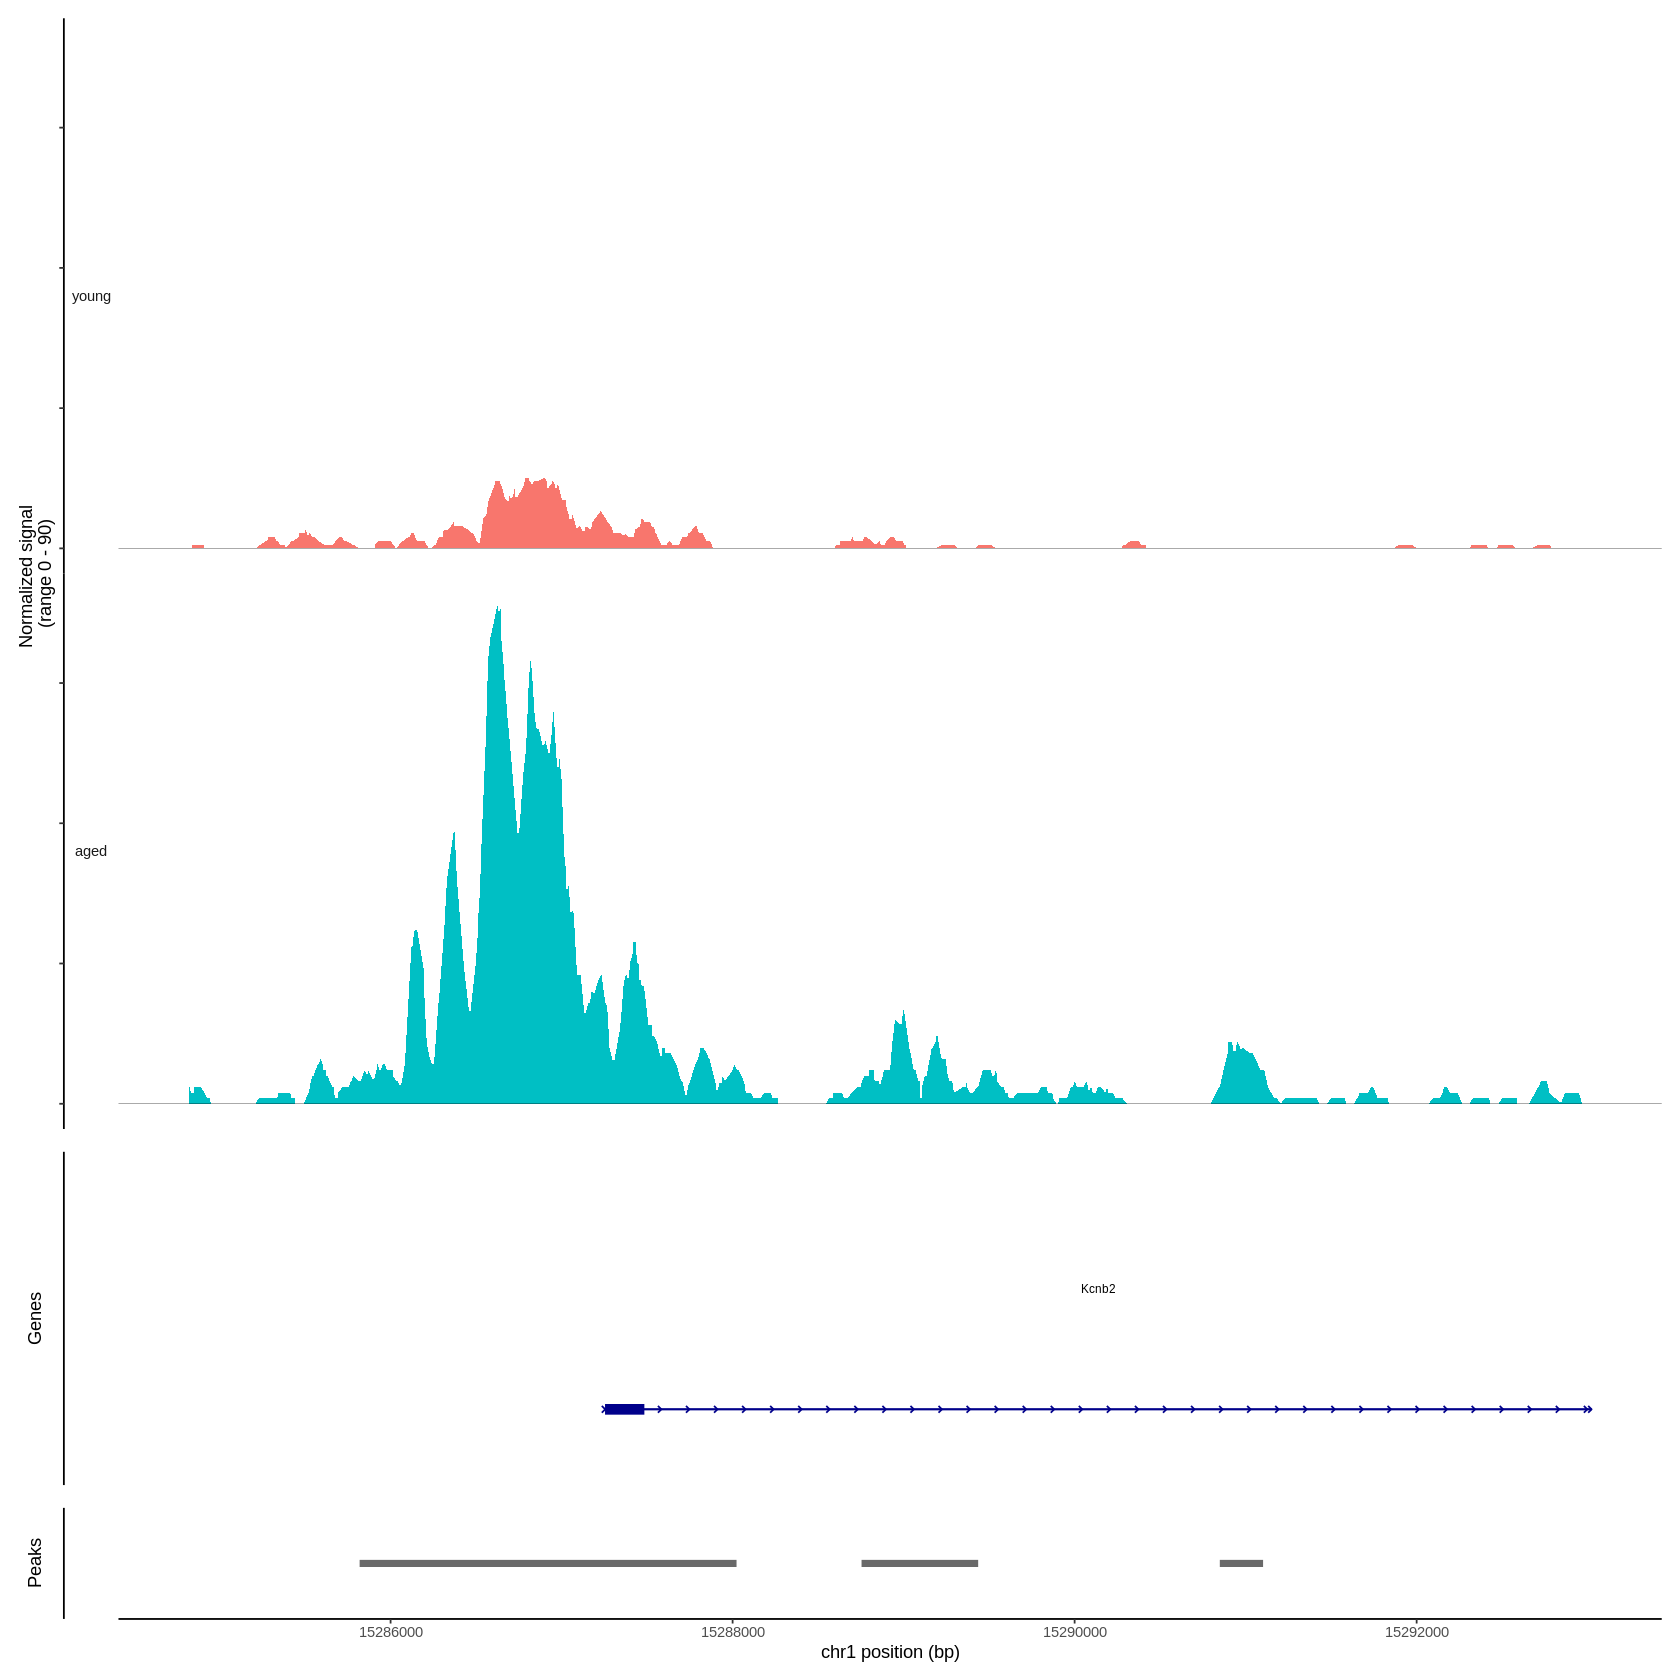

In [41]:
CoveragePlot(
  object = combined,
  region = "chr1-15285819-15288023",
  extend.upstream = 1000,
  extend.downstream = 5000
)

## Some biological conclusions from the paper

"To assess the correlation between changes in chromatin accessibility and transcription, DARs were connected to the nearest genes based on their distance to TSSs. The genes linked to Aged HSC open DARs showed significantly higher levels of expression in aged HSCs than young HSCs (Fig. 4e). Among 381 and 101 genes linked to Aged HSC open and closed DARs, respectively, 60 Aged HSC open genes and 11 Aged HSC closed genes showed up- and downregulation, respectively, greater than twofold in aged HSCs relative to young HSCs (Fig. 4f). Assuming that the genes nearest to DARs are not always the real target of transcriptional regulatory regions at DARs, these results indicate that a significant portion of DARs accounts for differential expression between young and aged HSCs. Of interest, the differential expression of representative DAR-linked genes, which showed expression changes greater than twofold with q values < 0.05 in aged HSCs, were sharply resolved upon differentiation (Fig. 4g)."

https://www.nature.com/articles/s41467-022-30440-2#Sec2

In [42]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/fmbuga/.conda/envs/Rv4-3/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: US/Pacific
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] EnsDb.Mmusculus.v79_2.99.0 ensembldb_2.24.1          
 [3] AnnotationFilter_1.24.0    GenomicFeatures_1.52.2    
 [5] AnnotationDbi_1.62.2       Biobase_2.60.0            
 [7] future_1.33.0              Genomi